In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
data = pd.read_csv(f"{os.path.dirname(os.path.abspath(''))}/bank-additional/bank-additional-full.csv", sep=";")

I've added some thoughts about NAs, ouliers and variable significance for each variable

1 - age (numeric) : No NAs.

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') - unknown will be considered NA. We will use the mode to replace them, since the proportion of unknown is considerably small.

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed): the same method as at the job column is applied.

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown'): knn to replace the unknown, since it is an ordinal variable.

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

Those three I would either ignore the variable if we can prove that it's not significant enough or keep it as if unknown were another category. Default has more unknown than yes so is probable that it will be discarded. Housing has a similar frequency in both so we can compare between the frequencies they have of each y category. Loan has a few more yes than unknown but the solution of using the mode can be considered.


Related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone'): no NAs

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec'): no NAs

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri'): no NAs

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model: no NAs


Other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact): no NAs

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted): I would include a binary column with if the client has been contacted before. Not sure how to handle the 999 since the different scale can't be keep that extreme

14 - previous: number of contacts performed before this campaign and for this client (numeric): no NA

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success'): considering the frequency table, it will be ignore or considered nonexistent like another value.


Social and economic context attributes

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric) :  no NAs

17 - cons.price.idx: consumer price index - monthly indicator (numeric) : no NAs. judging the std it has, it highly likely that it won't give much information

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) :  no NAs

19 - euribor3m: euribor 3 month rate - daily indicator (numeric): no NAs

20 - nr.employed: number of employees - quarterly indicator (numeric): no NAs


Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [3]:
data.shape

(41188, 21)

In [4]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


---------------------------------------------------------------------------------
age:


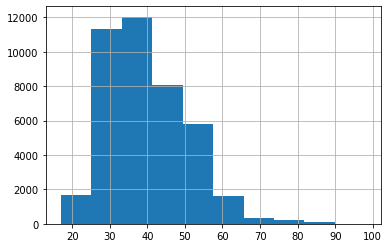

---------------------------------------------------------------------------------
duration:


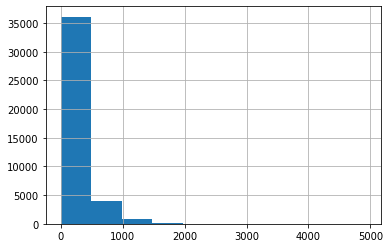

---------------------------------------------------------------------------------
campaign:


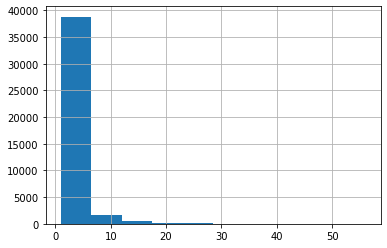

---------------------------------------------------------------------------------
pdays:


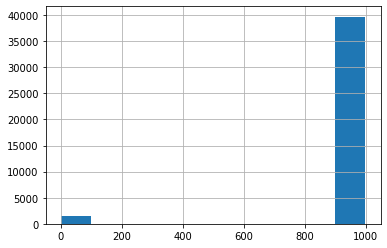

---------------------------------------------------------------------------------
previous:


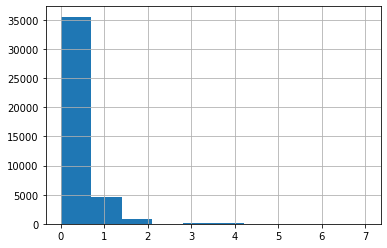

---------------------------------------------------------------------------------
emp.var.rate:


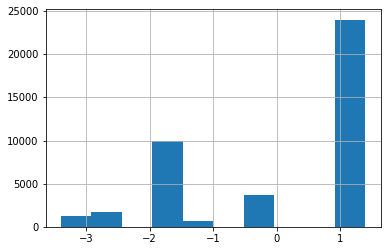

---------------------------------------------------------------------------------
cons.price.idx:


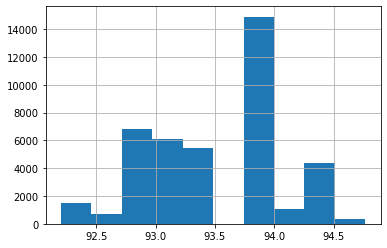

---------------------------------------------------------------------------------
cons.conf.idx:


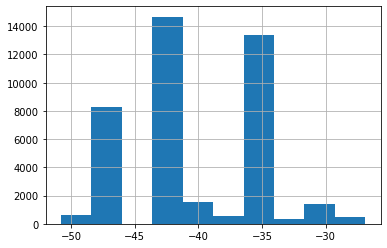

---------------------------------------------------------------------------------
euribor3m:


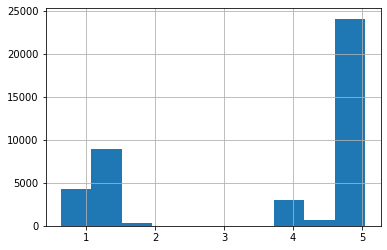

---------------------------------------------------------------------------------
nr.employed:


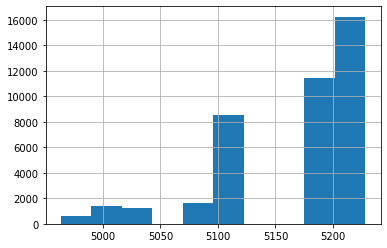

In [5]:
for col in data.describe().columns:
    print("---------------------------------------------------------------------------------")
    print(col + ':')
    data.loc[:, col].hist()
    plt.show()

In [6]:
data.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


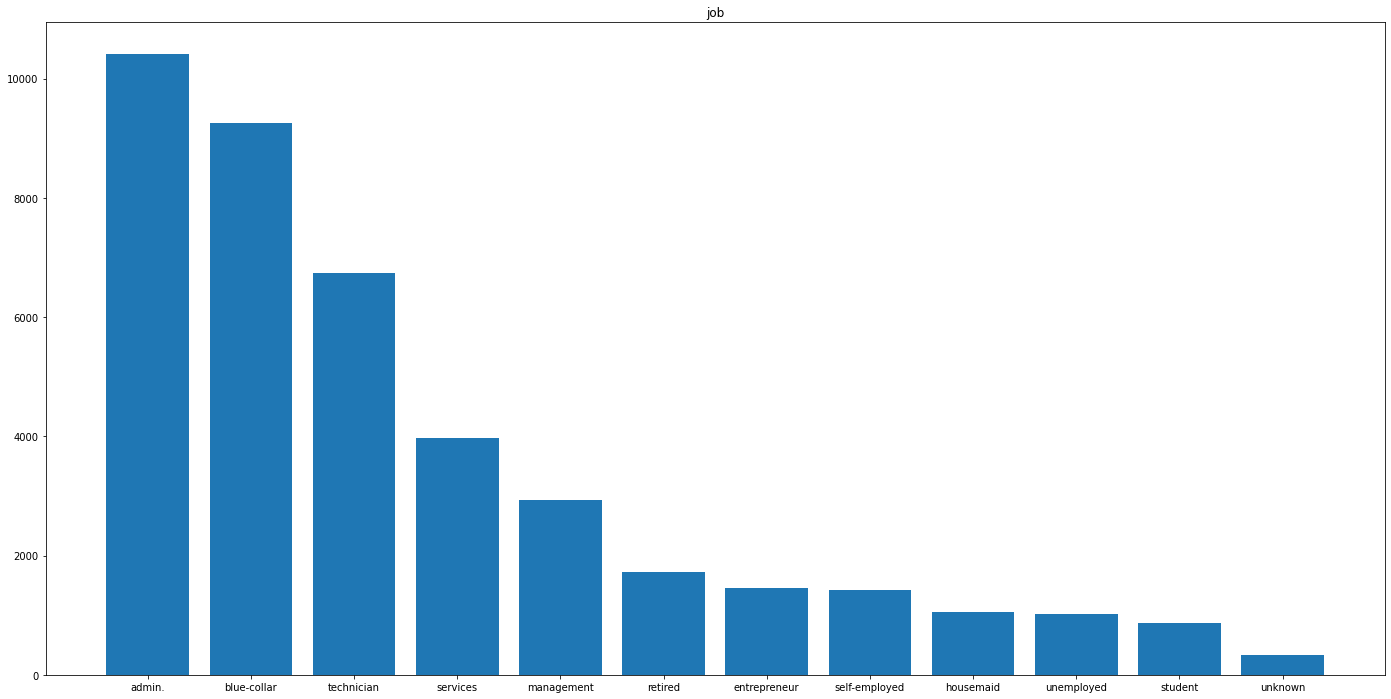

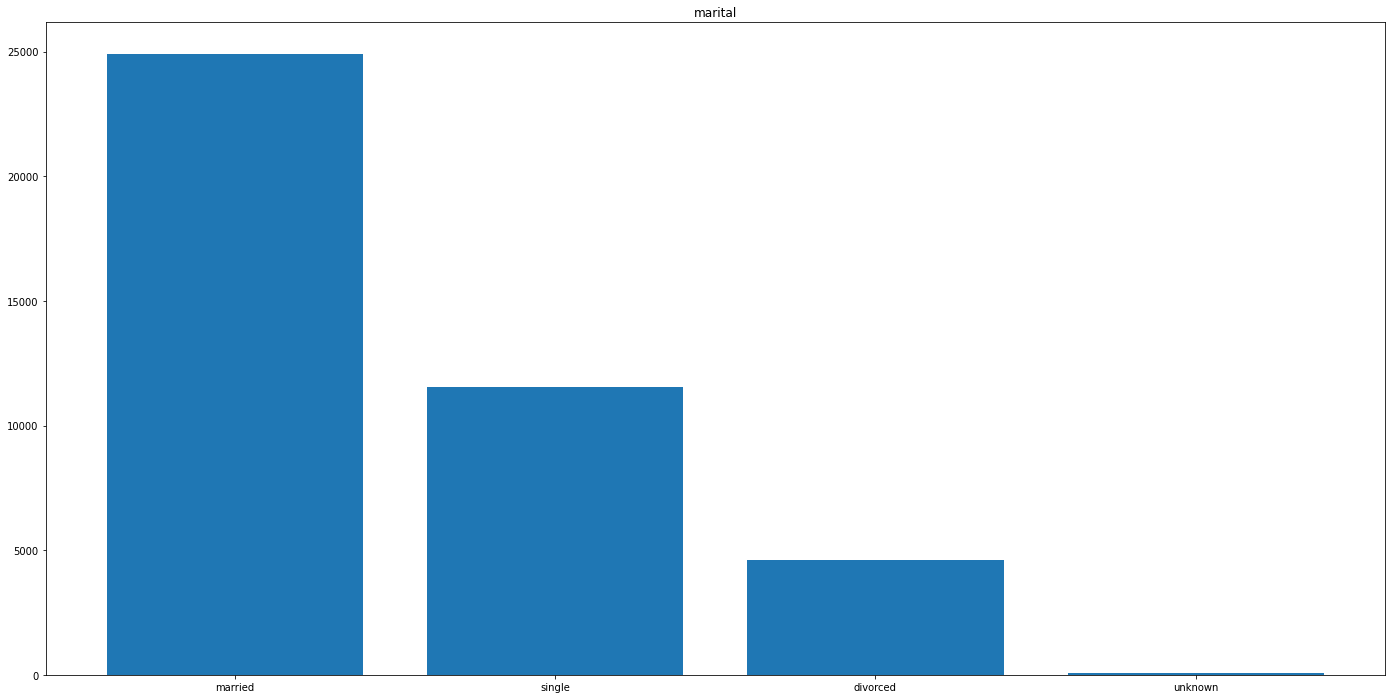

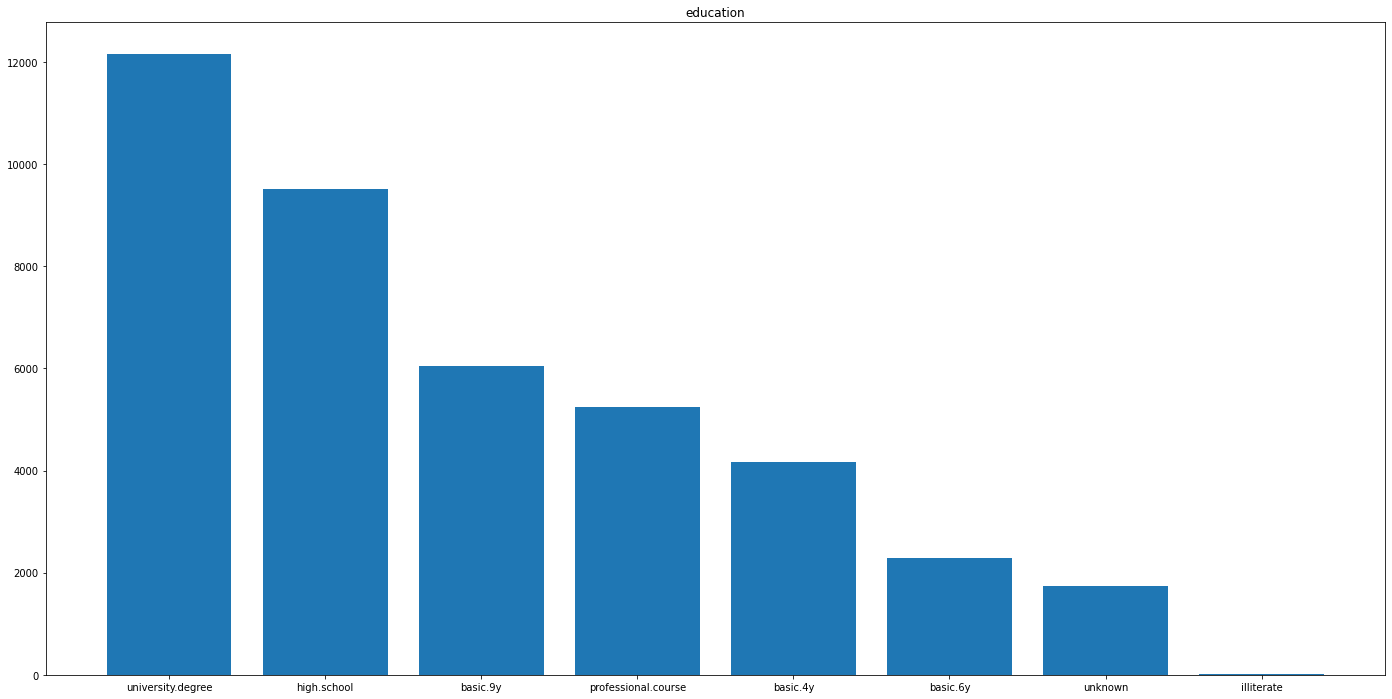

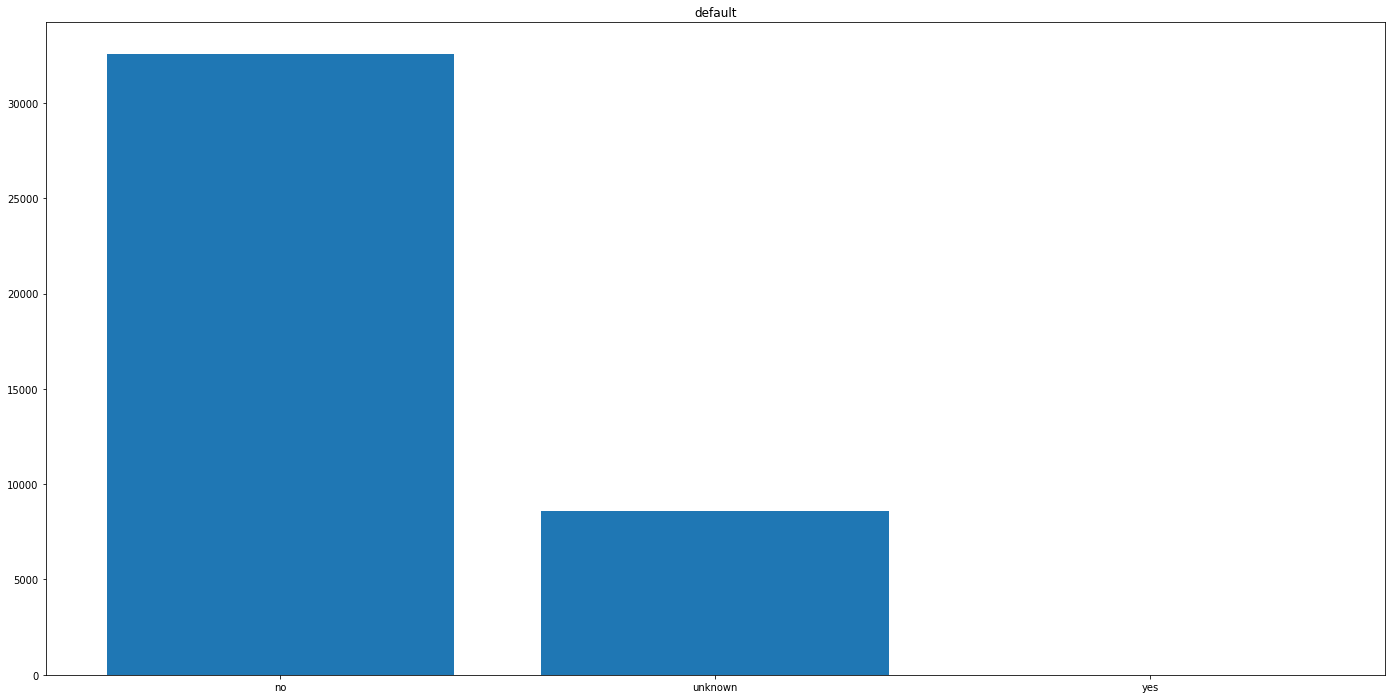

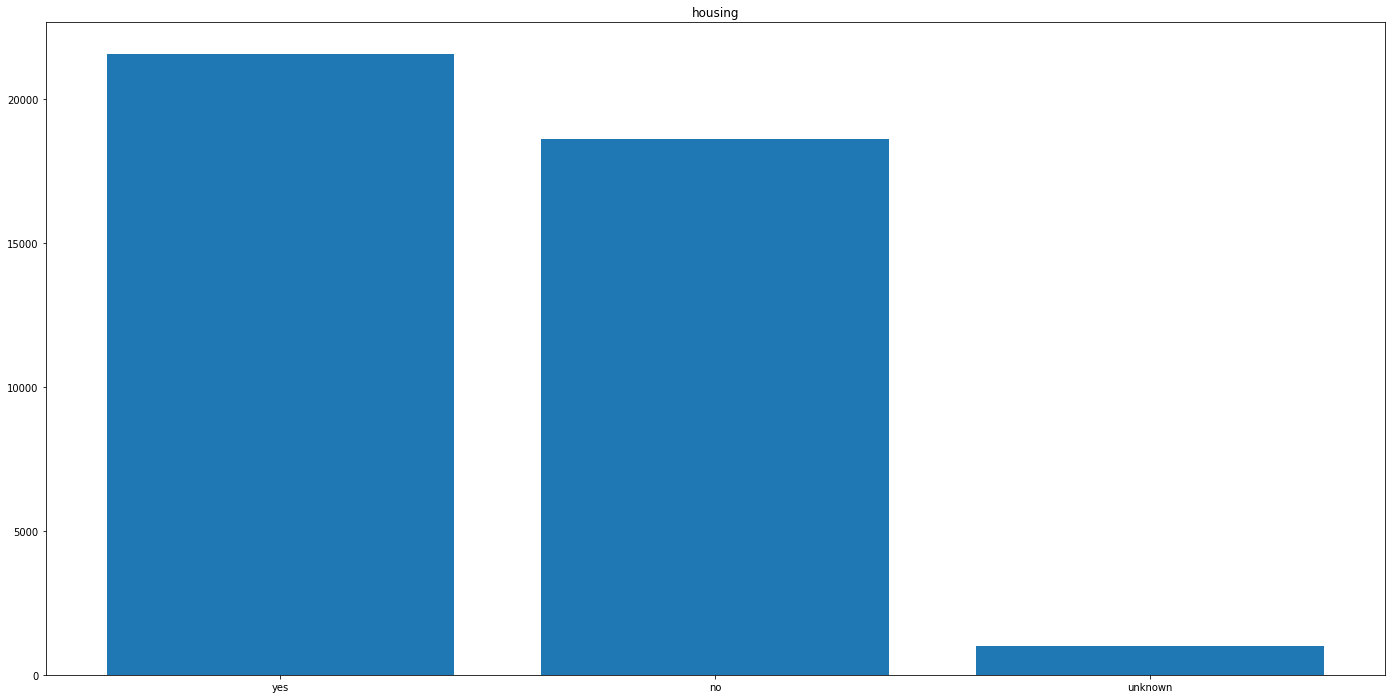

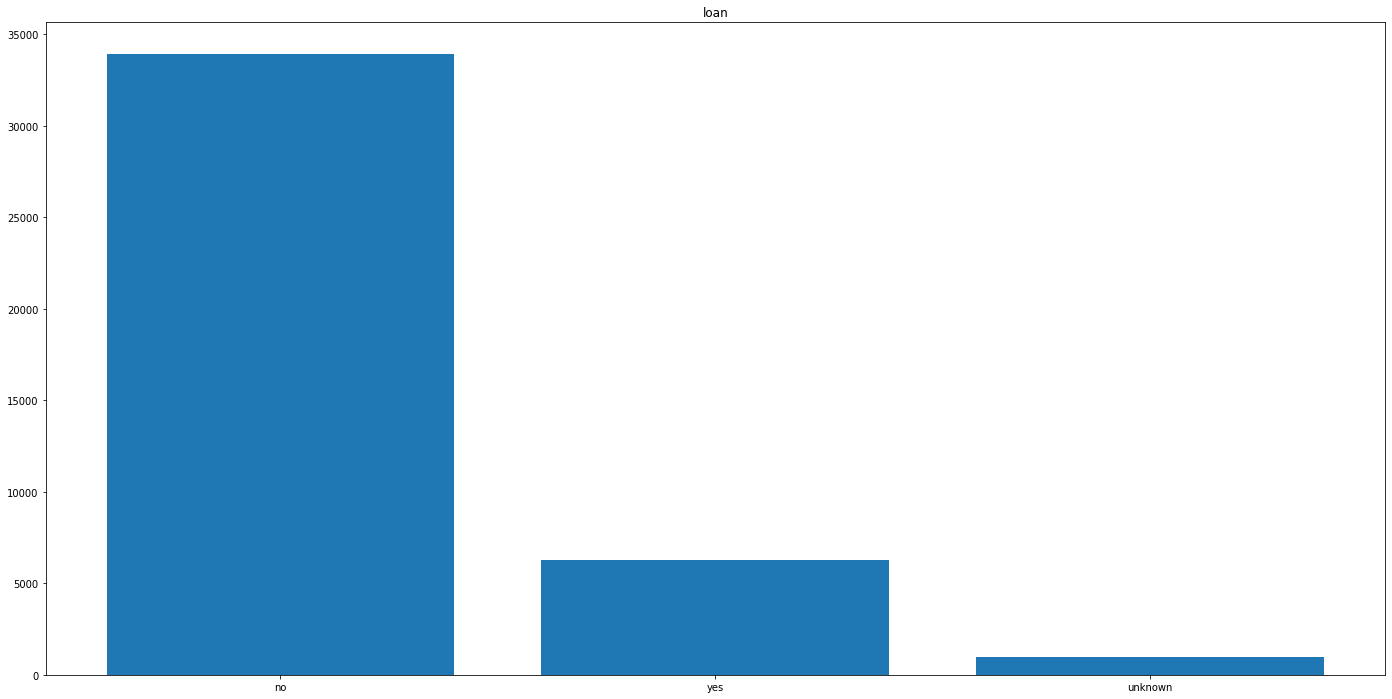

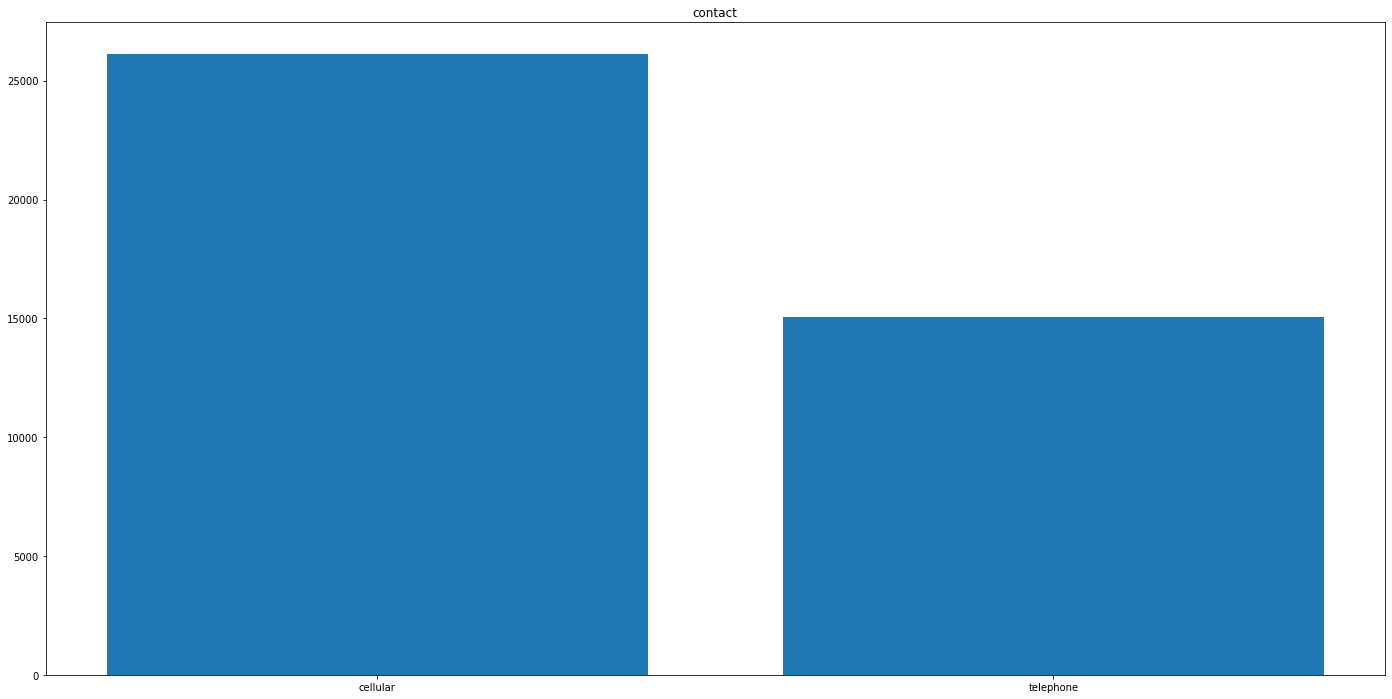

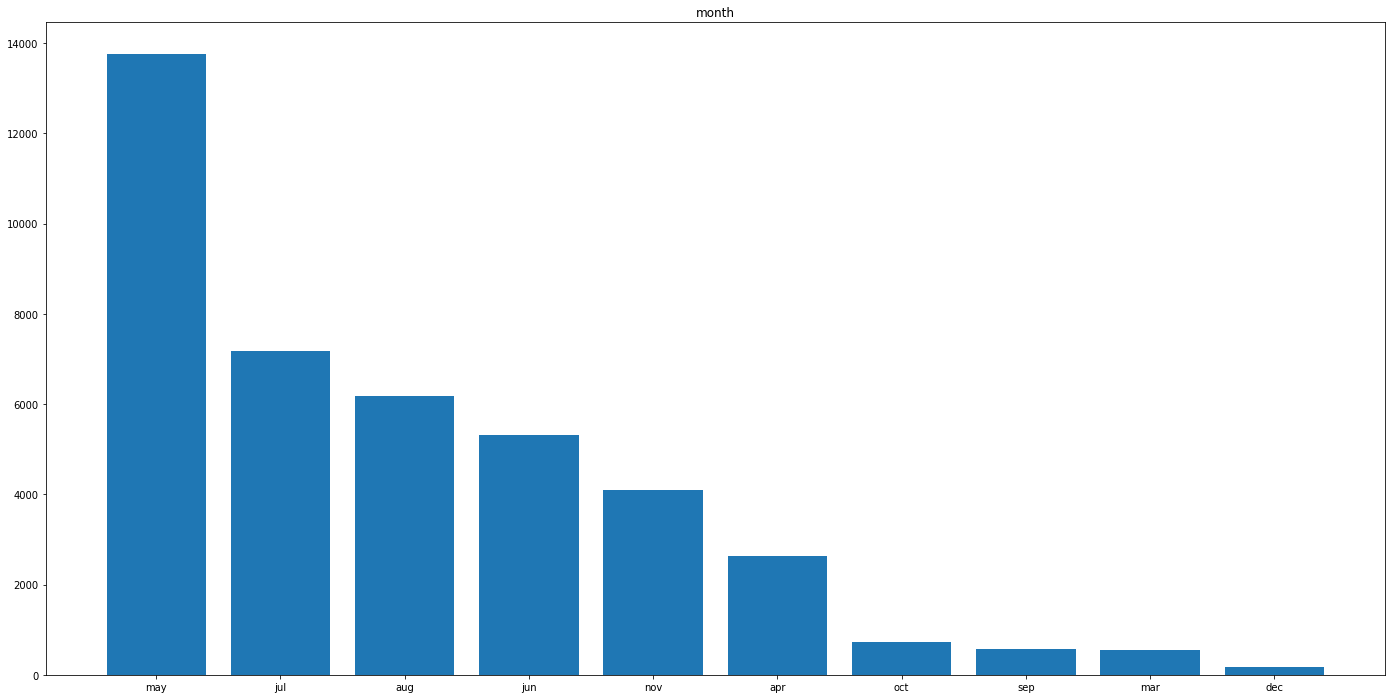

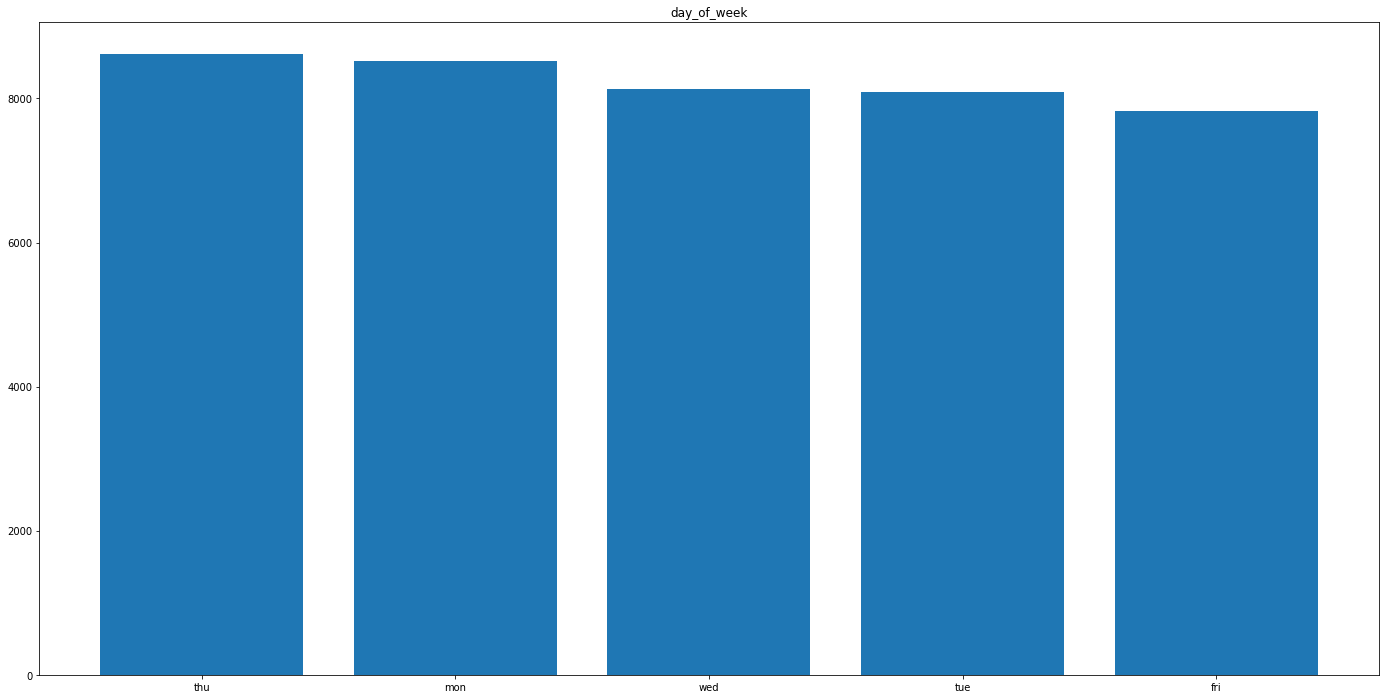

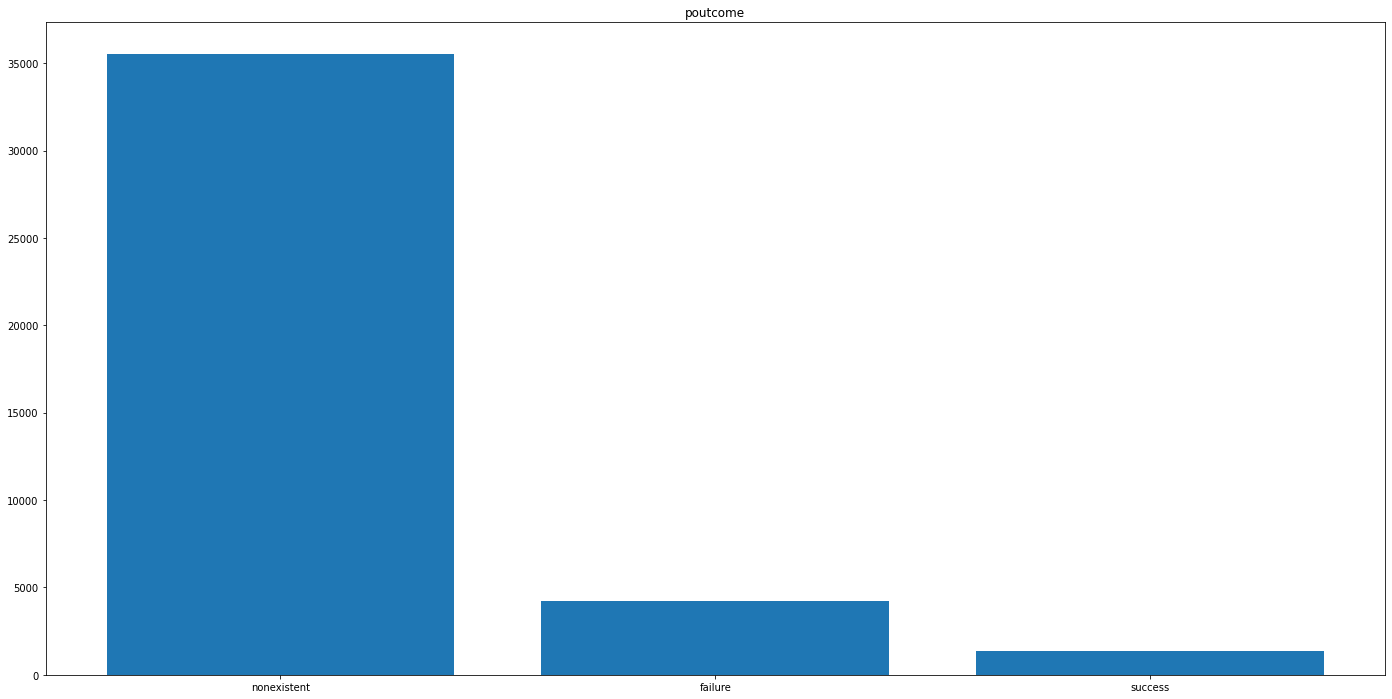

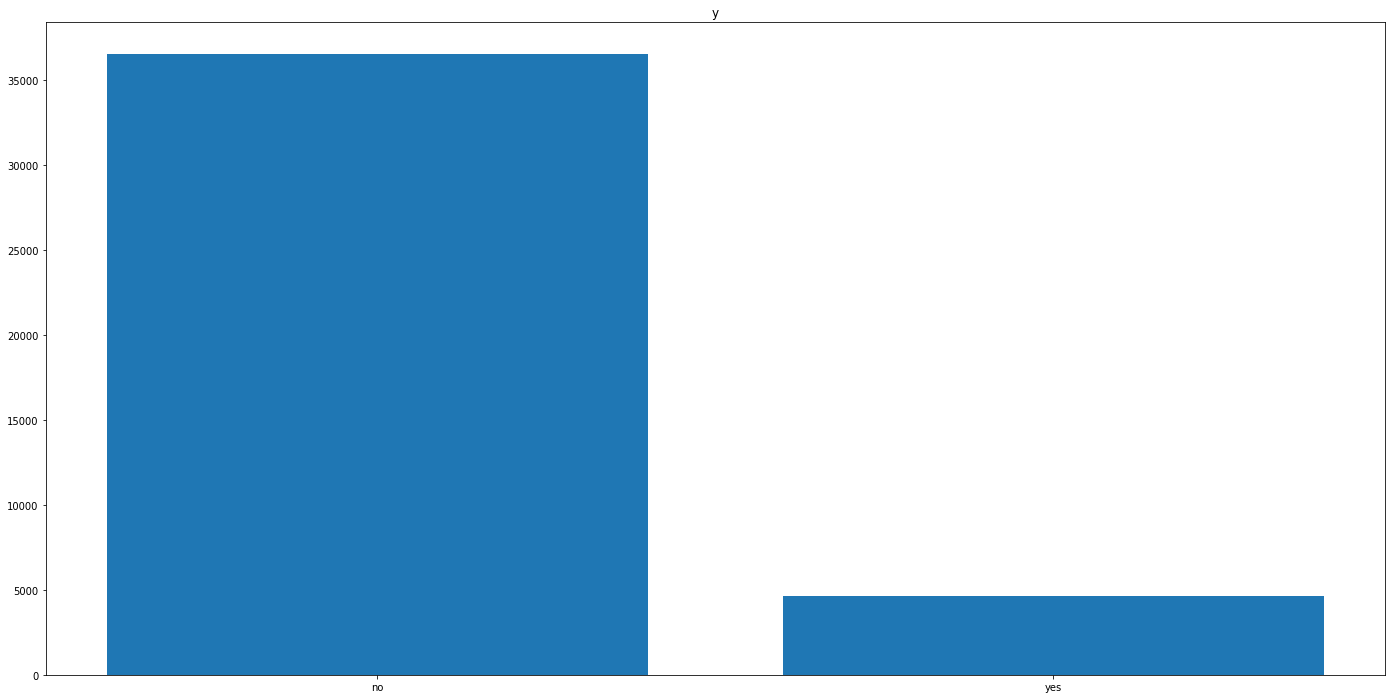

In [7]:
for col in data.describe(include='object').columns:
    fig, ax = plt.subplots(figsize=(24, 12))
    
    ax.bar(data.loc[:, col].value_counts().index, data.loc[:, col].value_counts().values)
    ax.set_title(col)

    plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


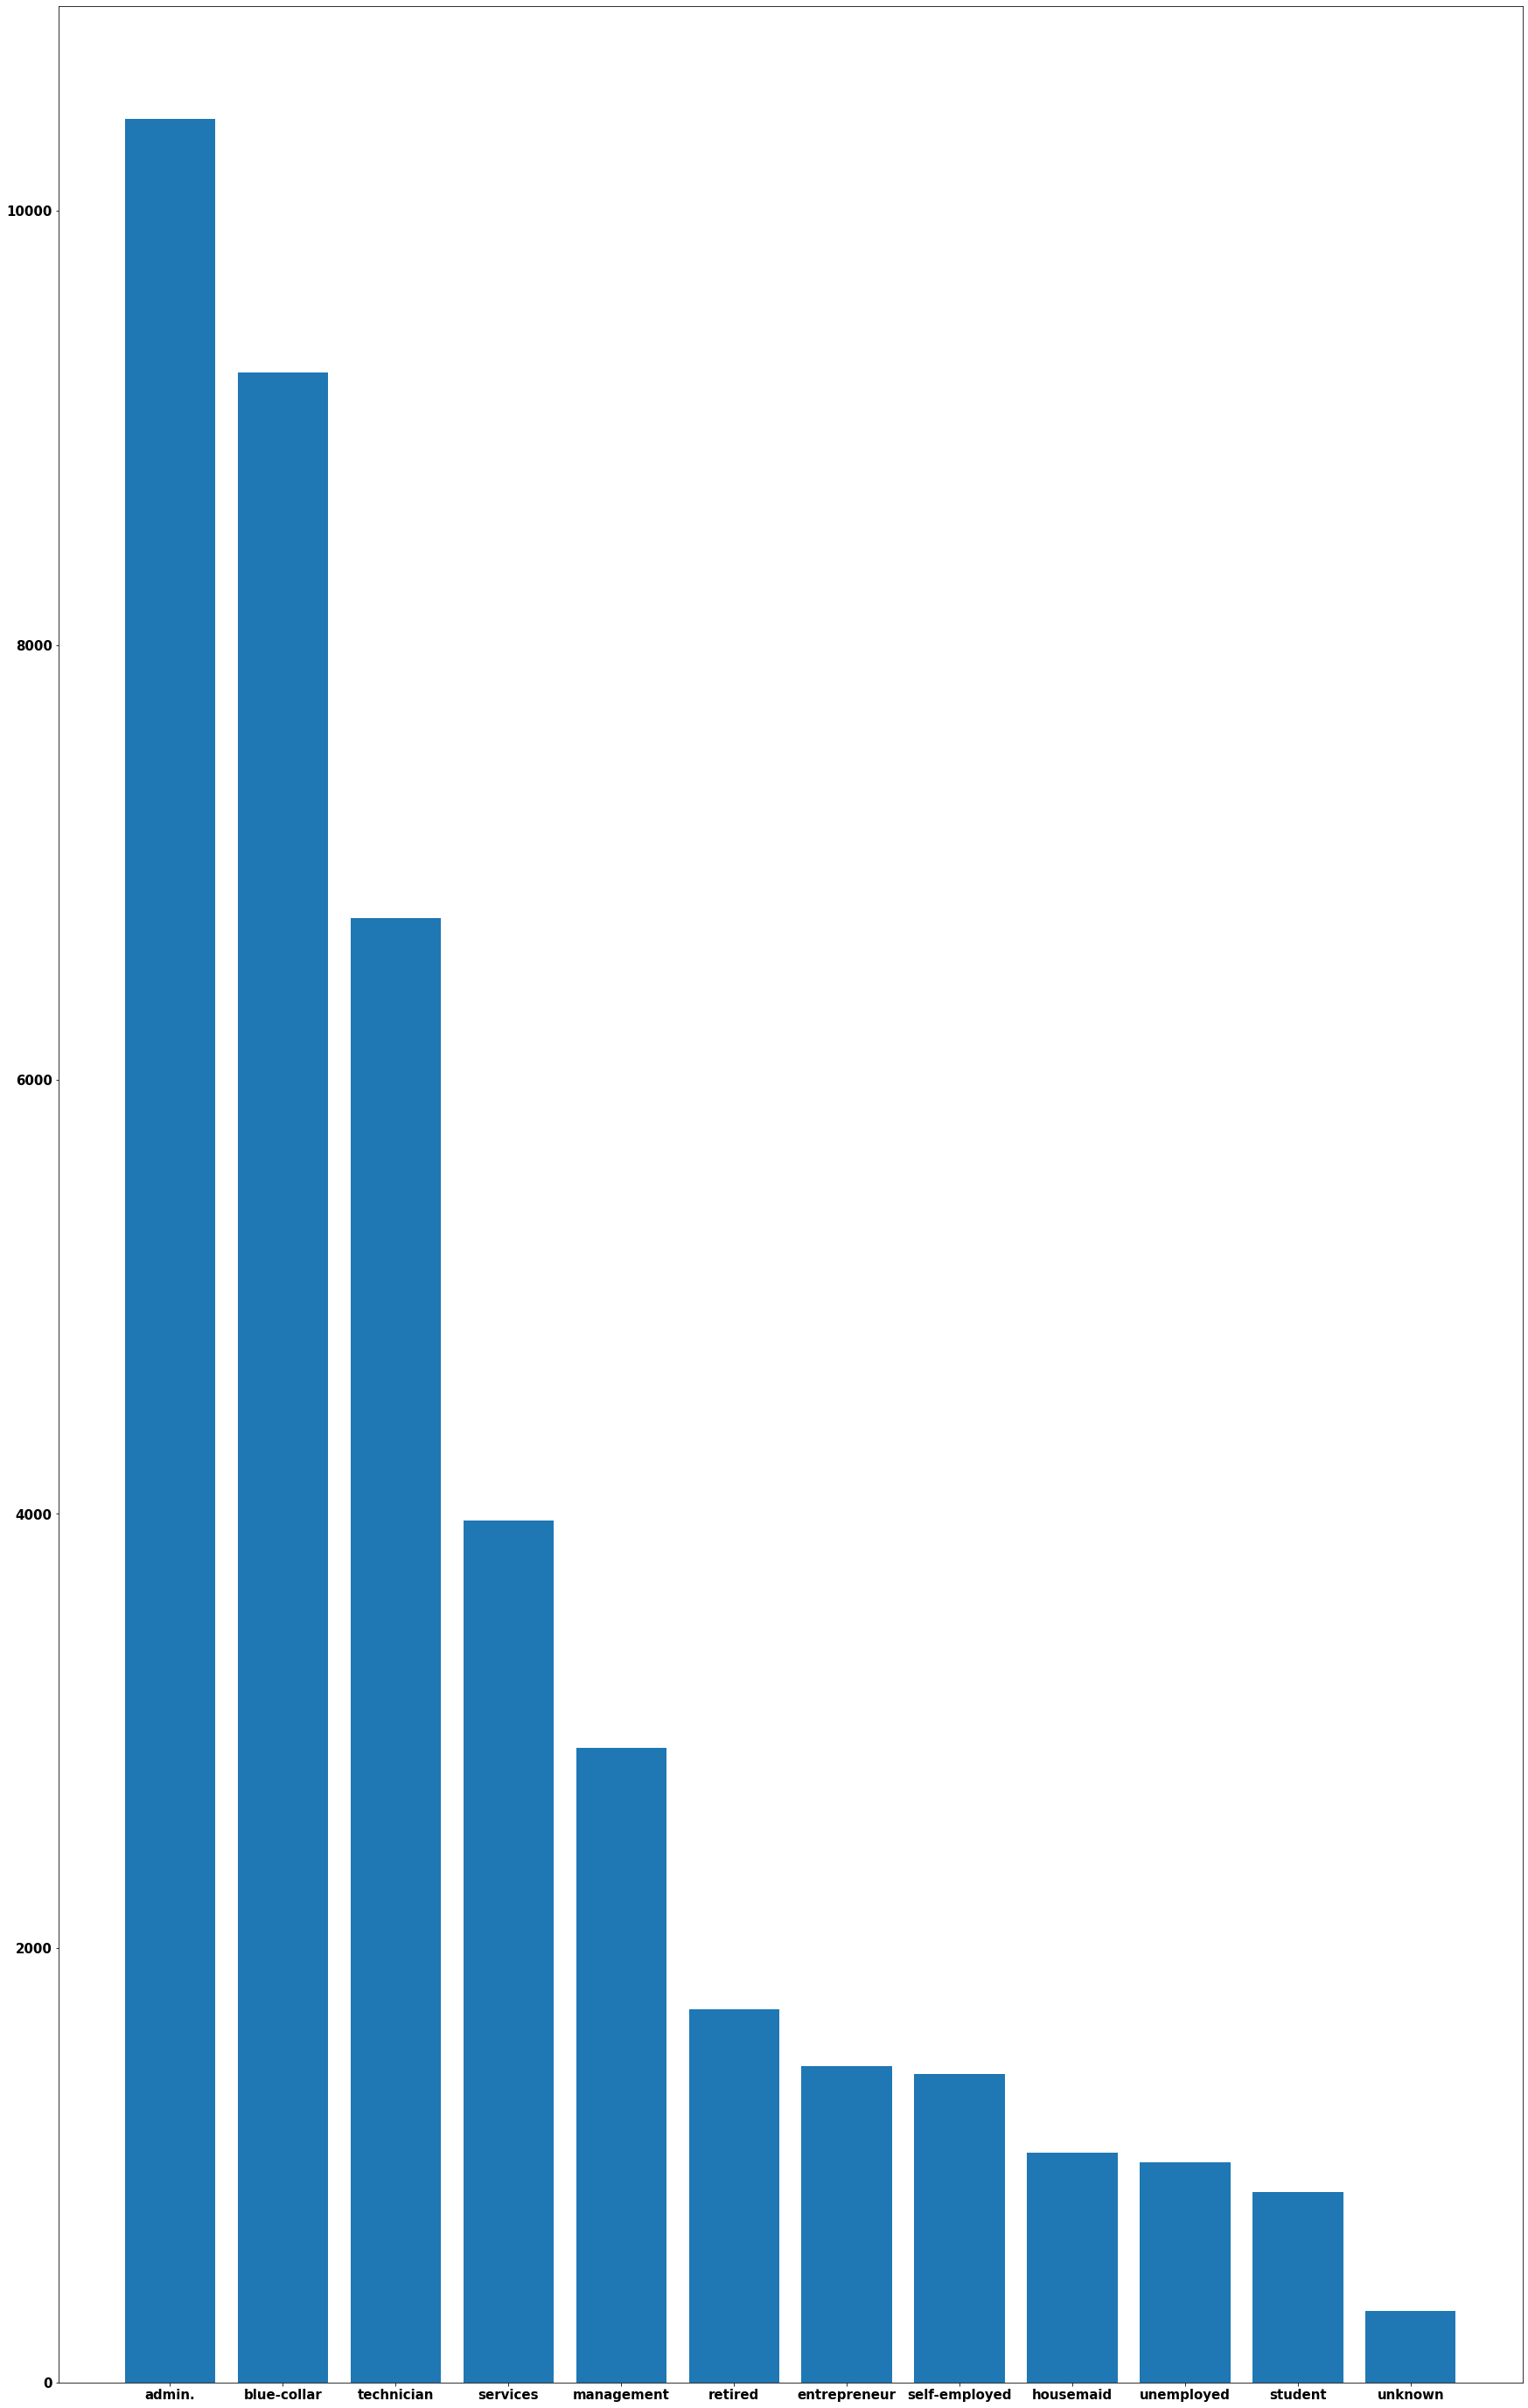

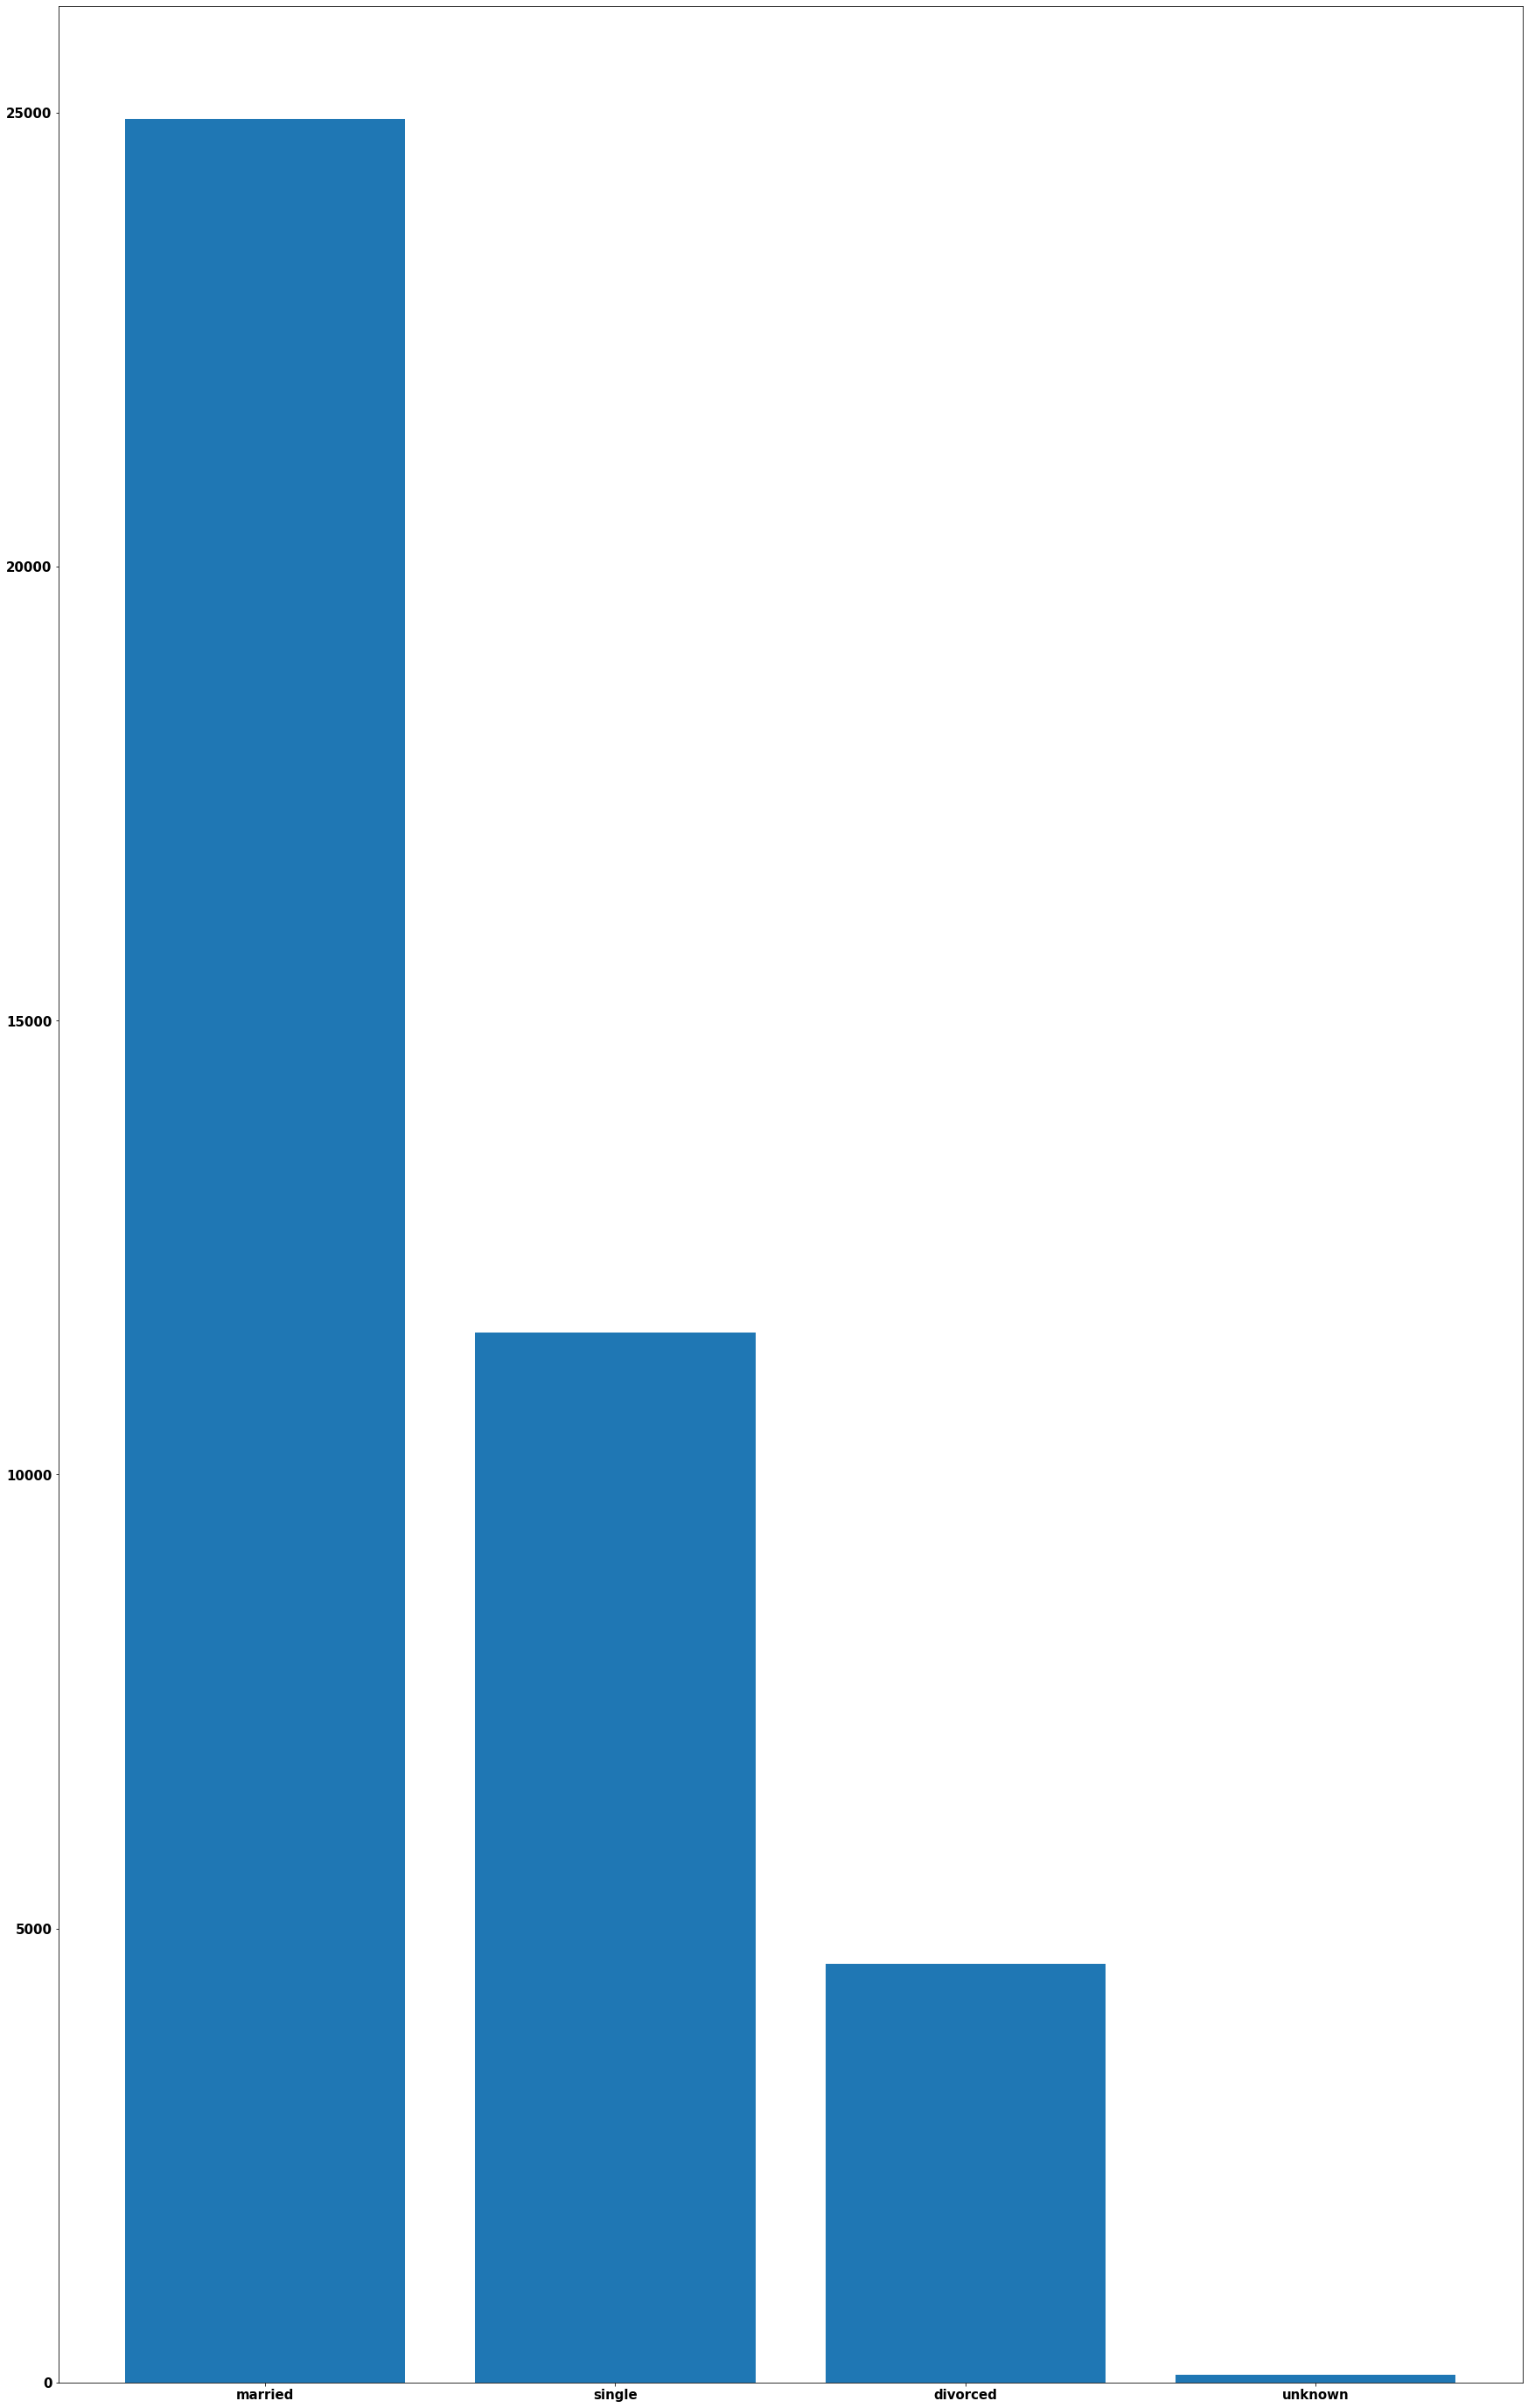

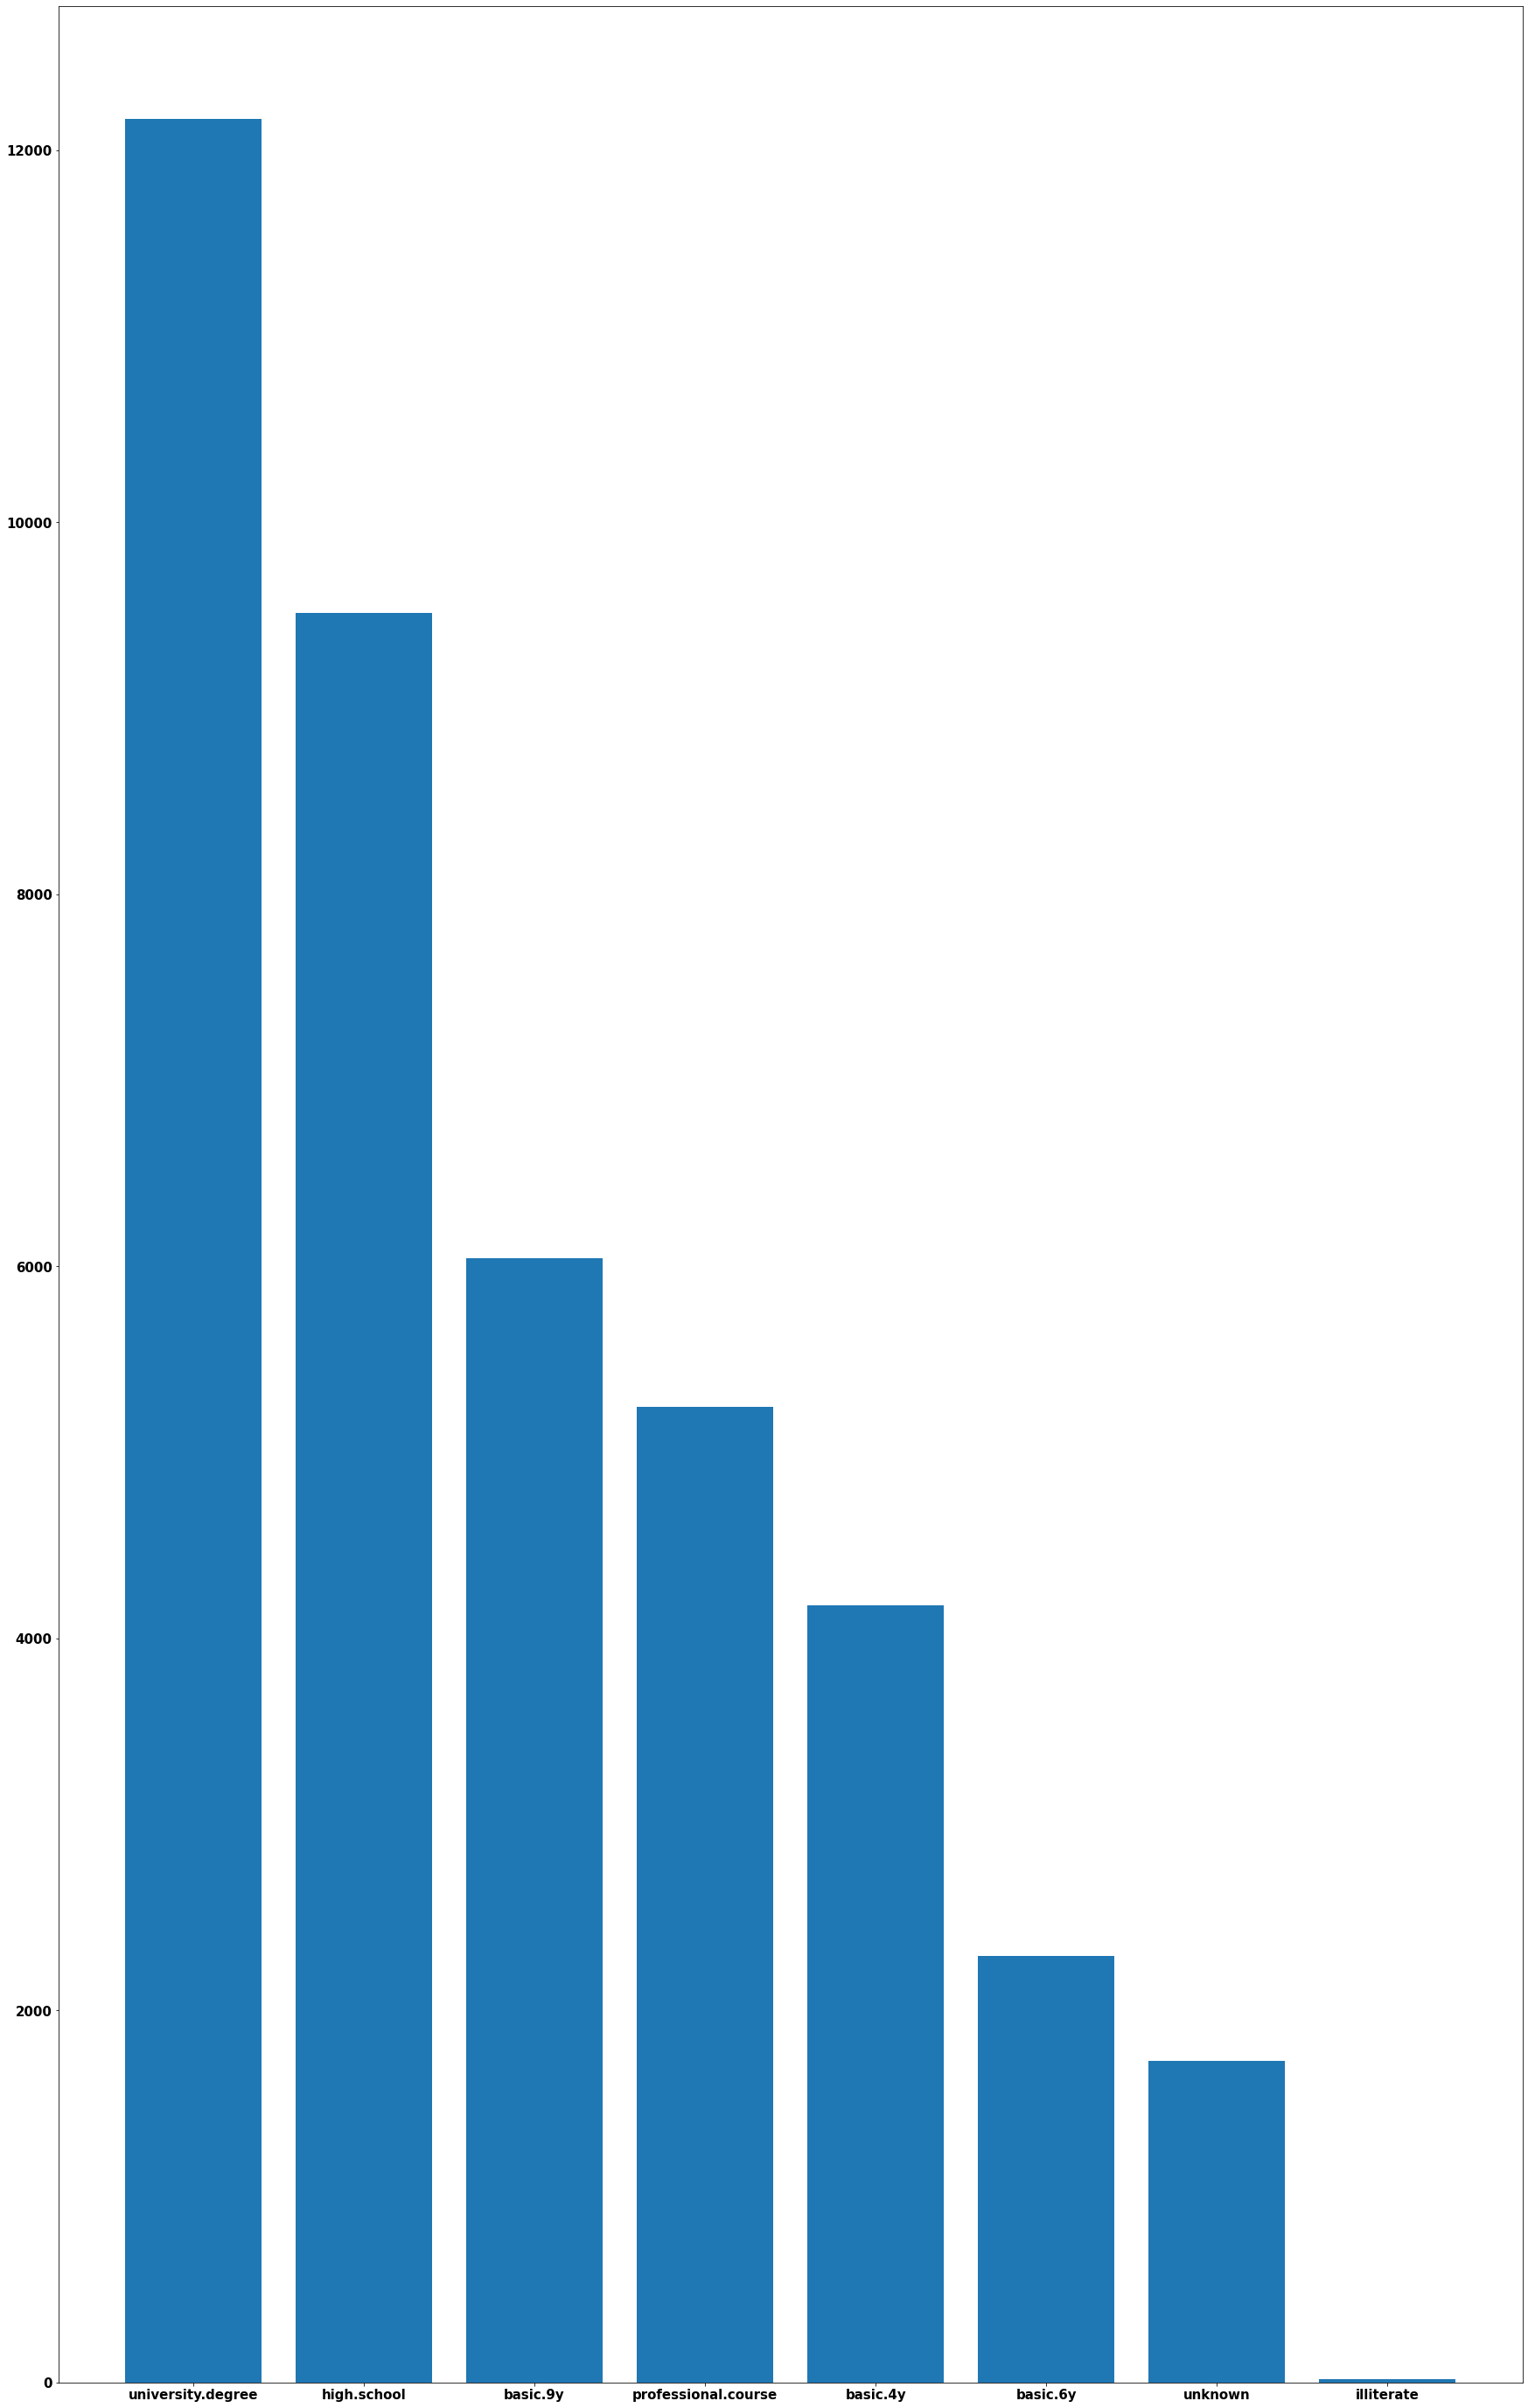

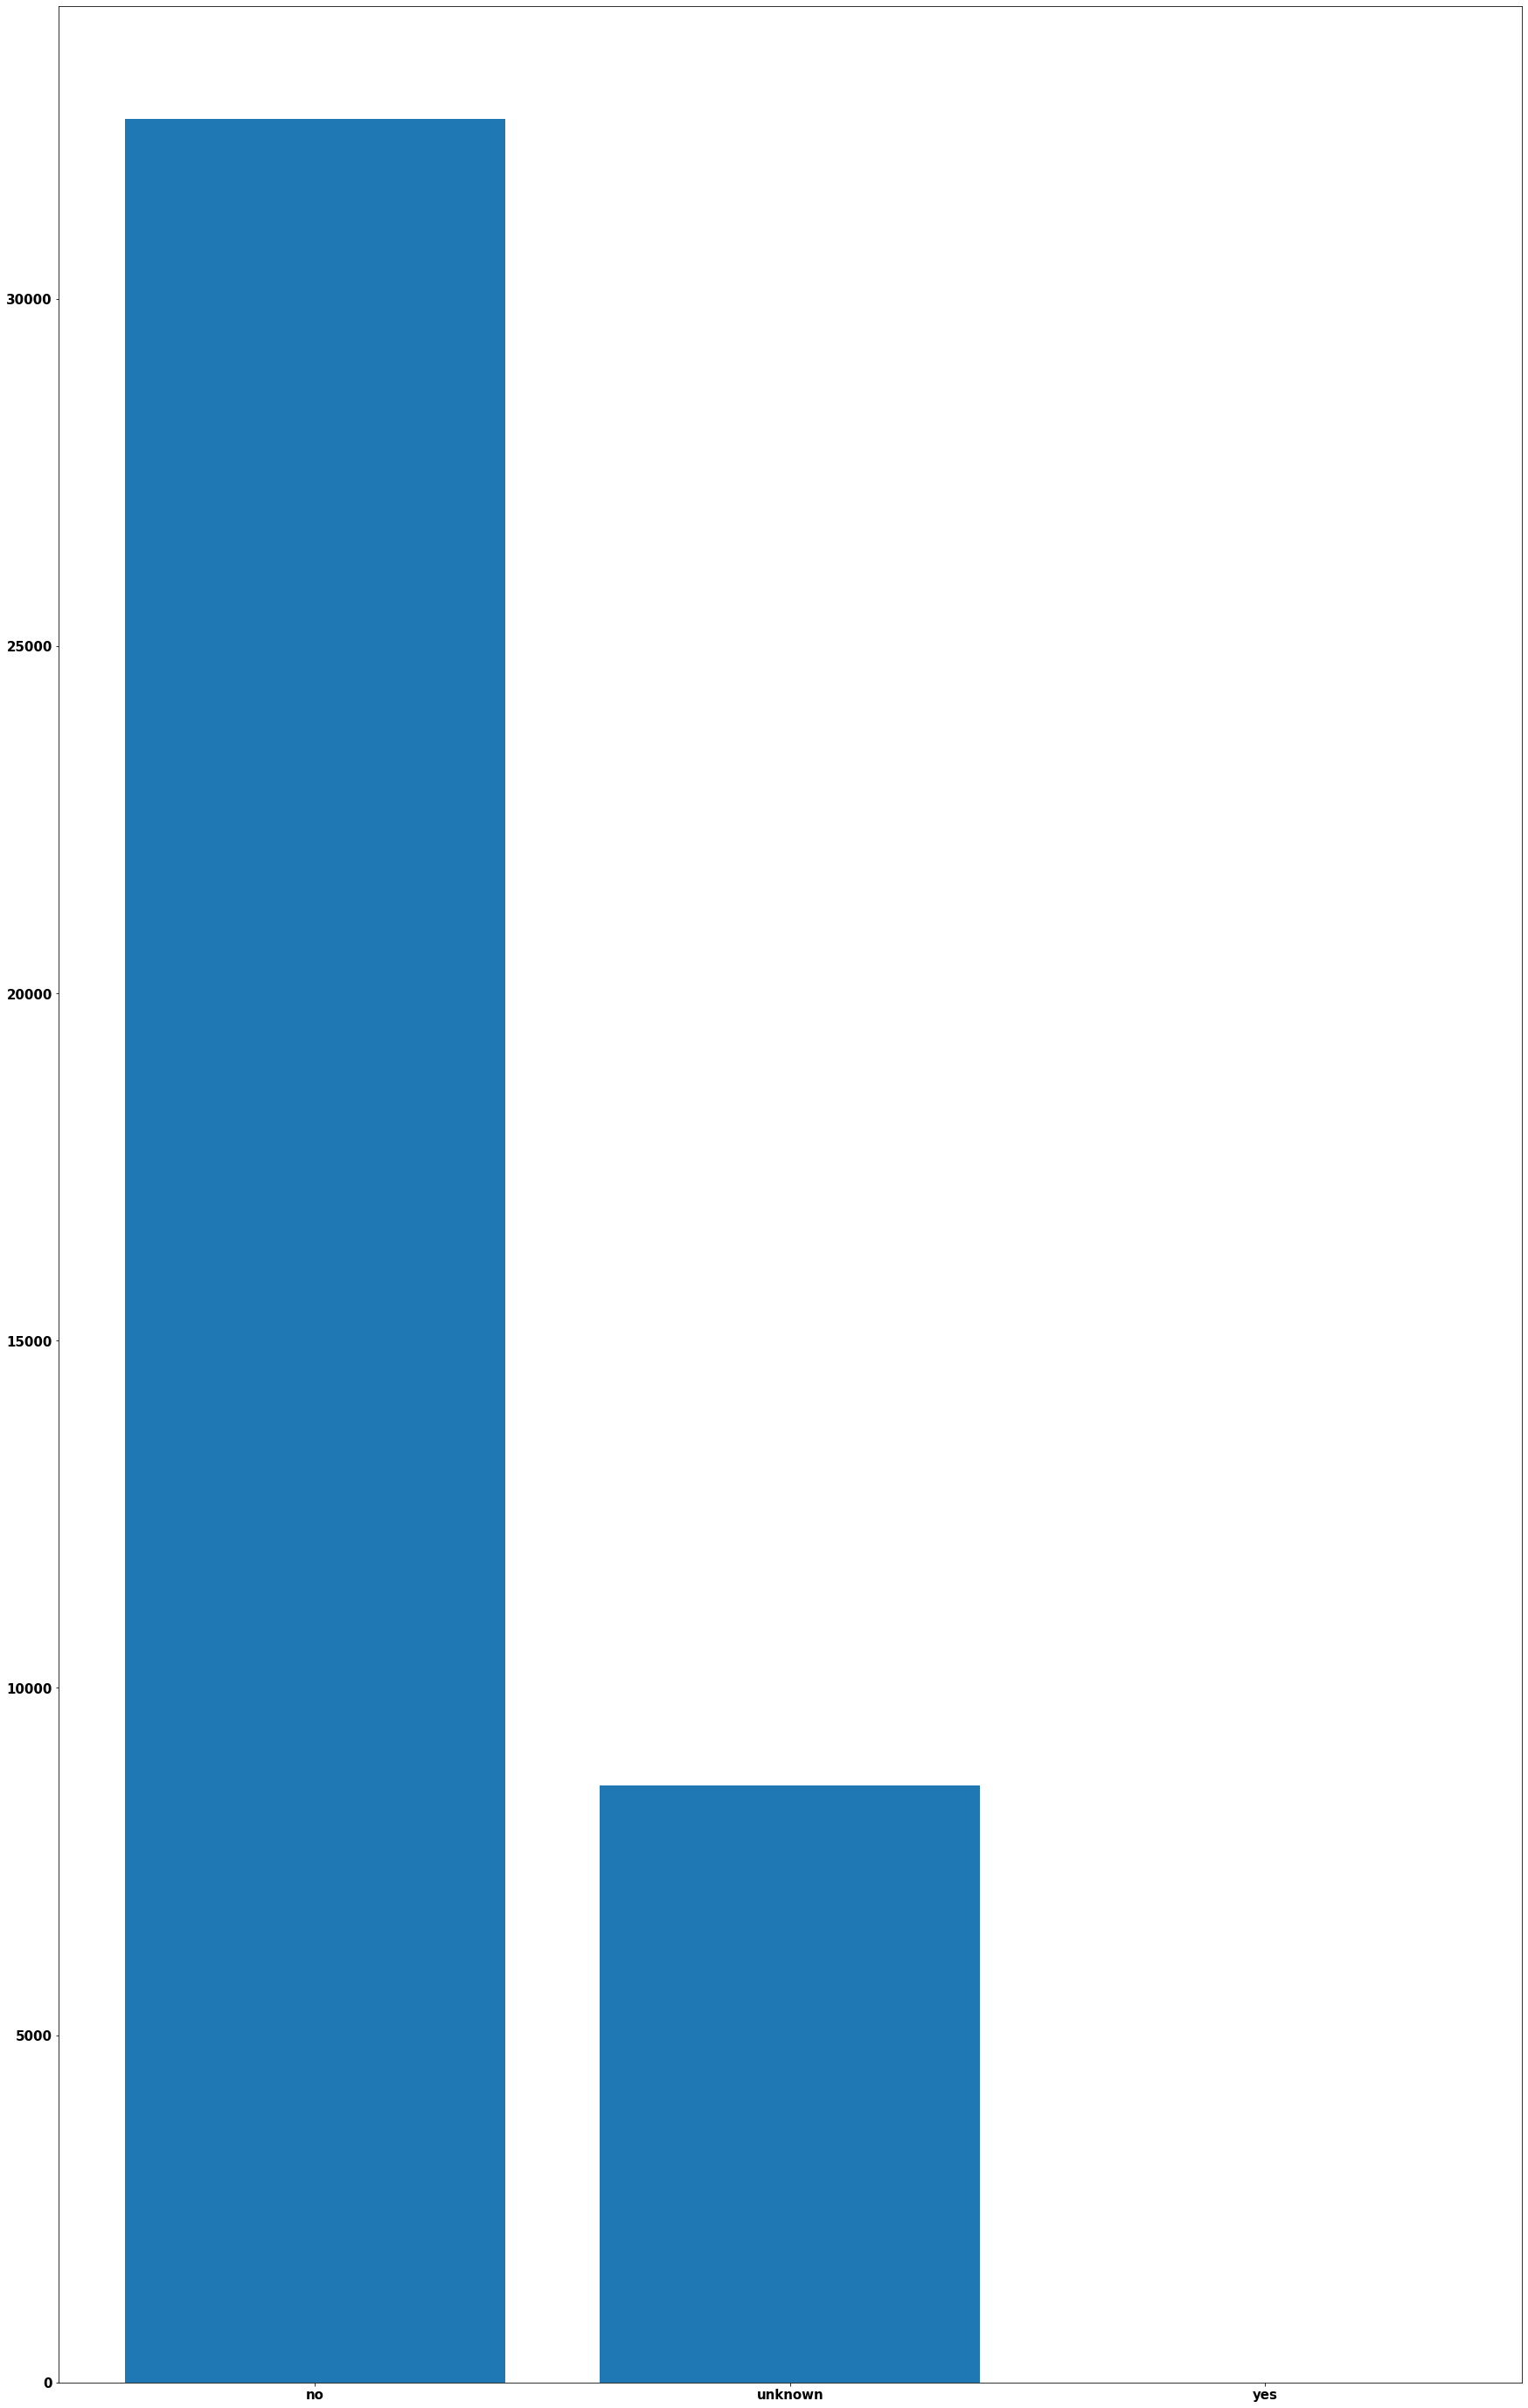

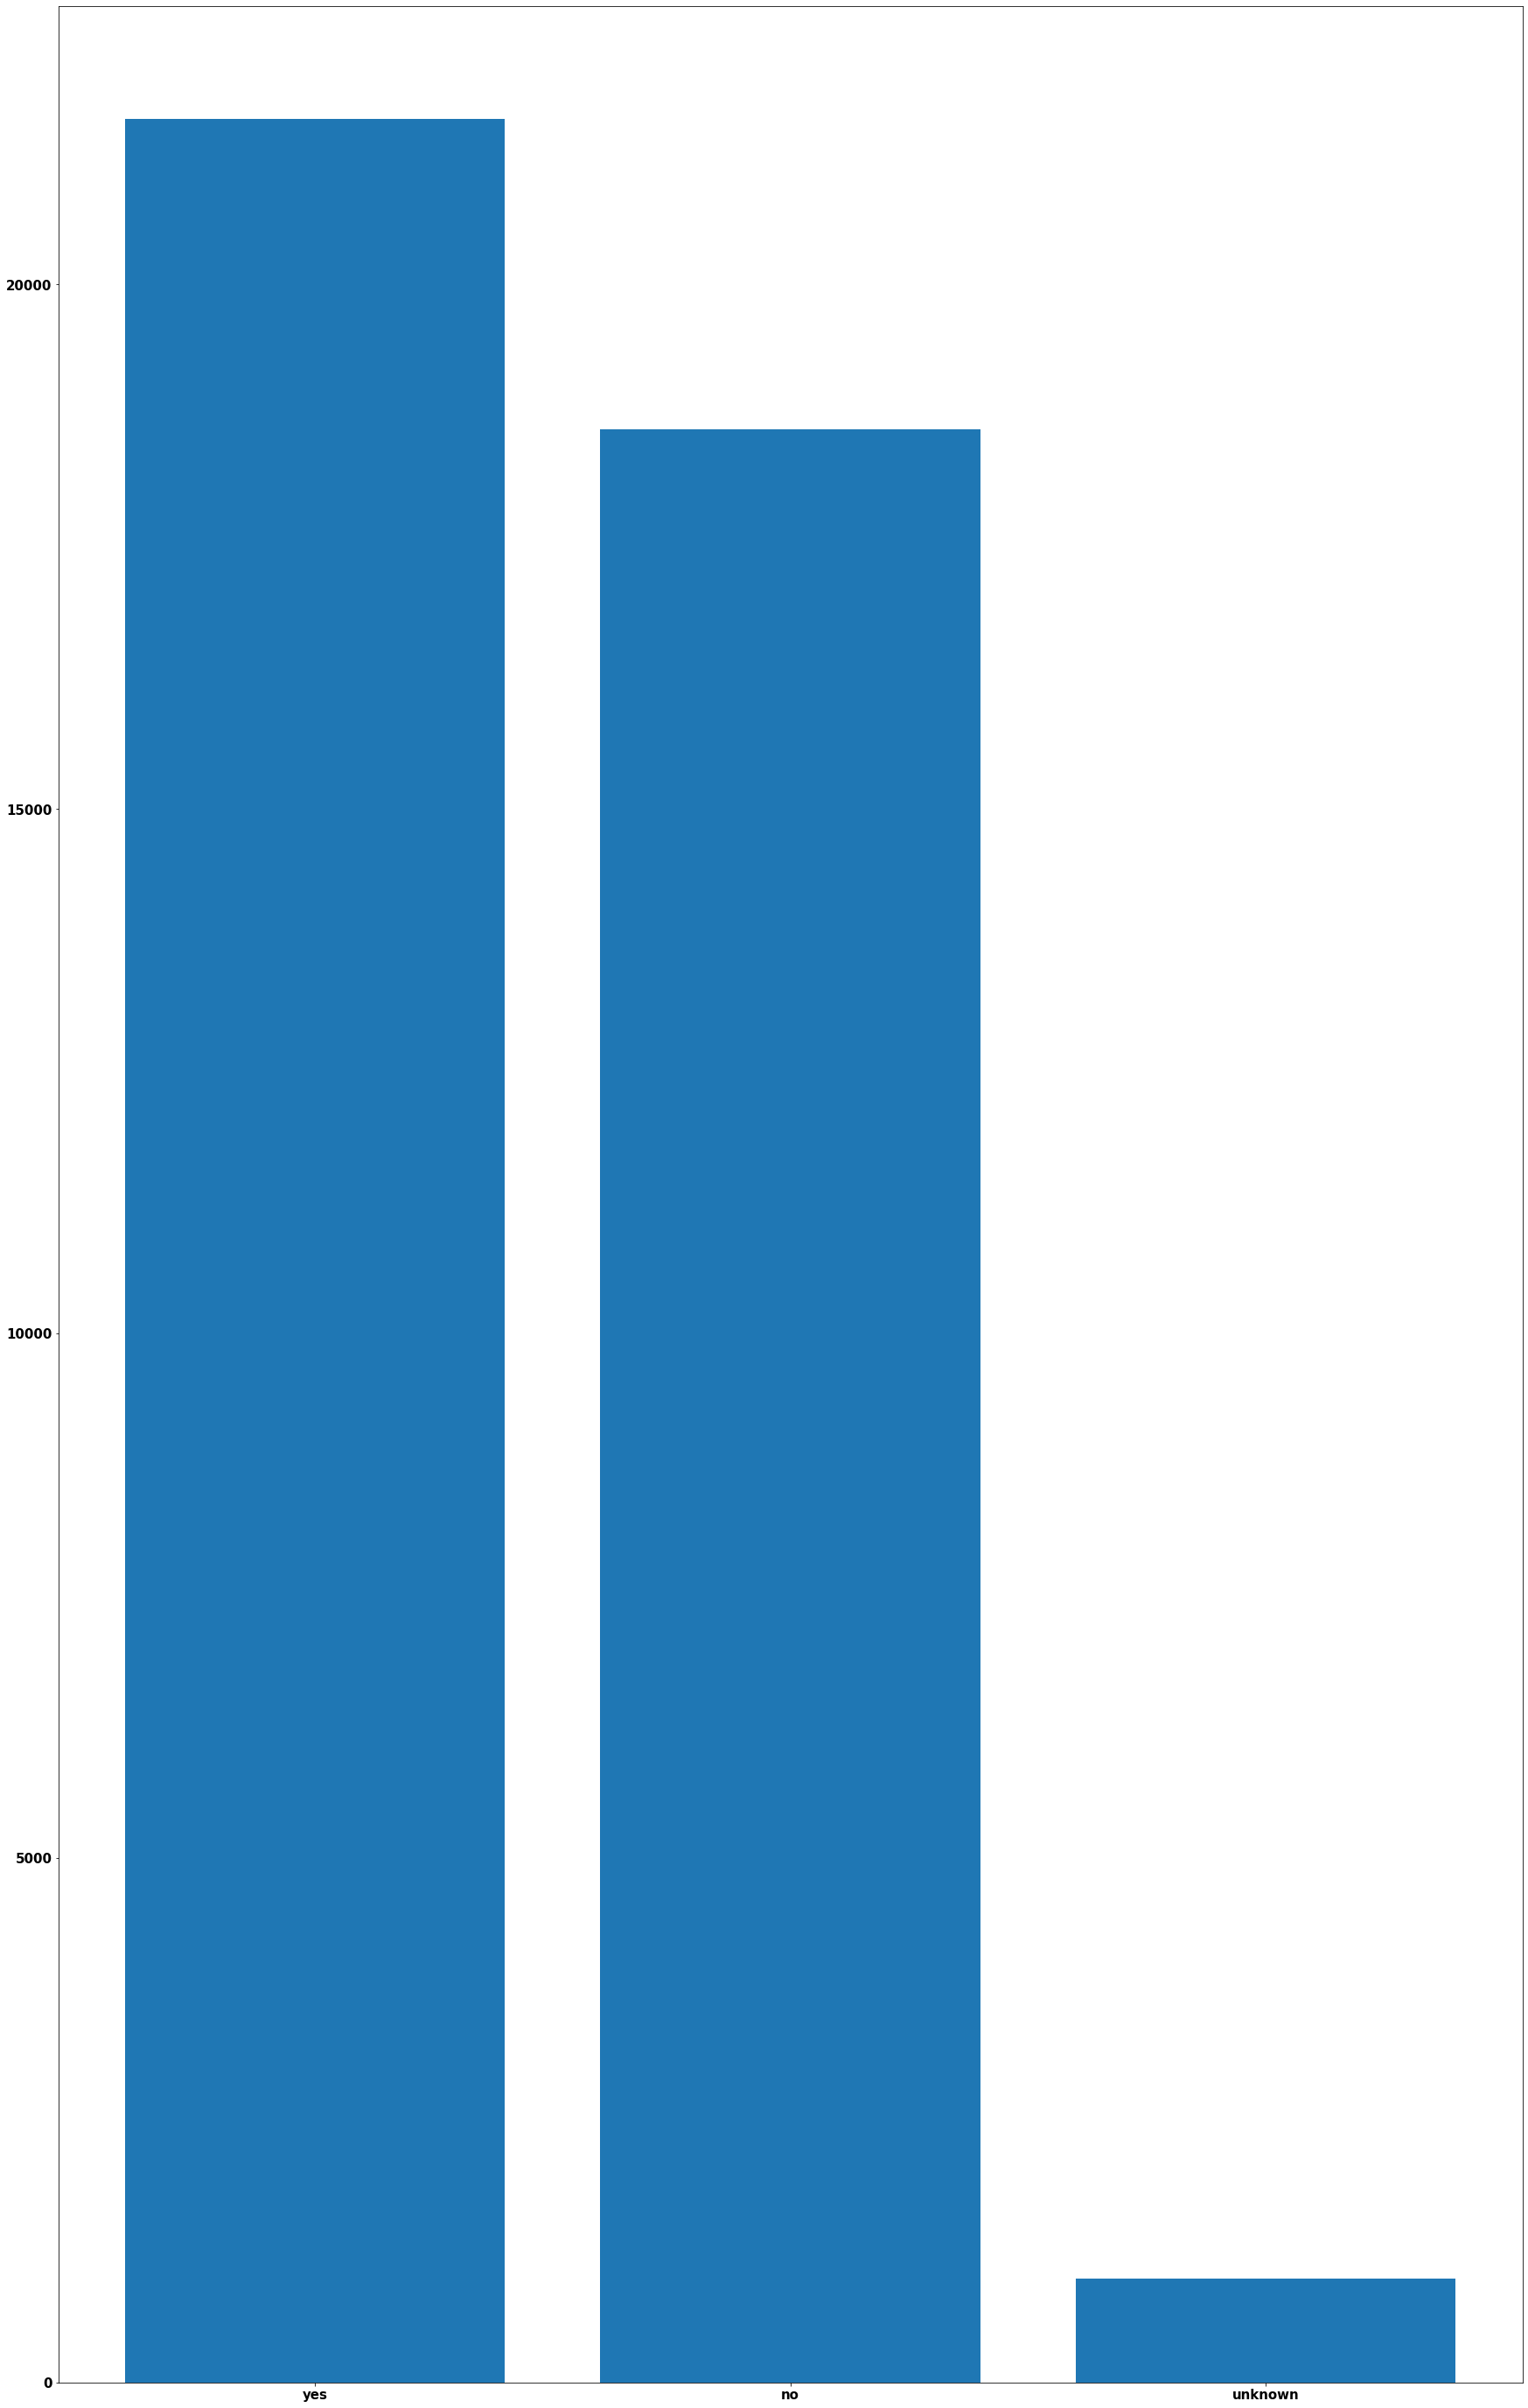

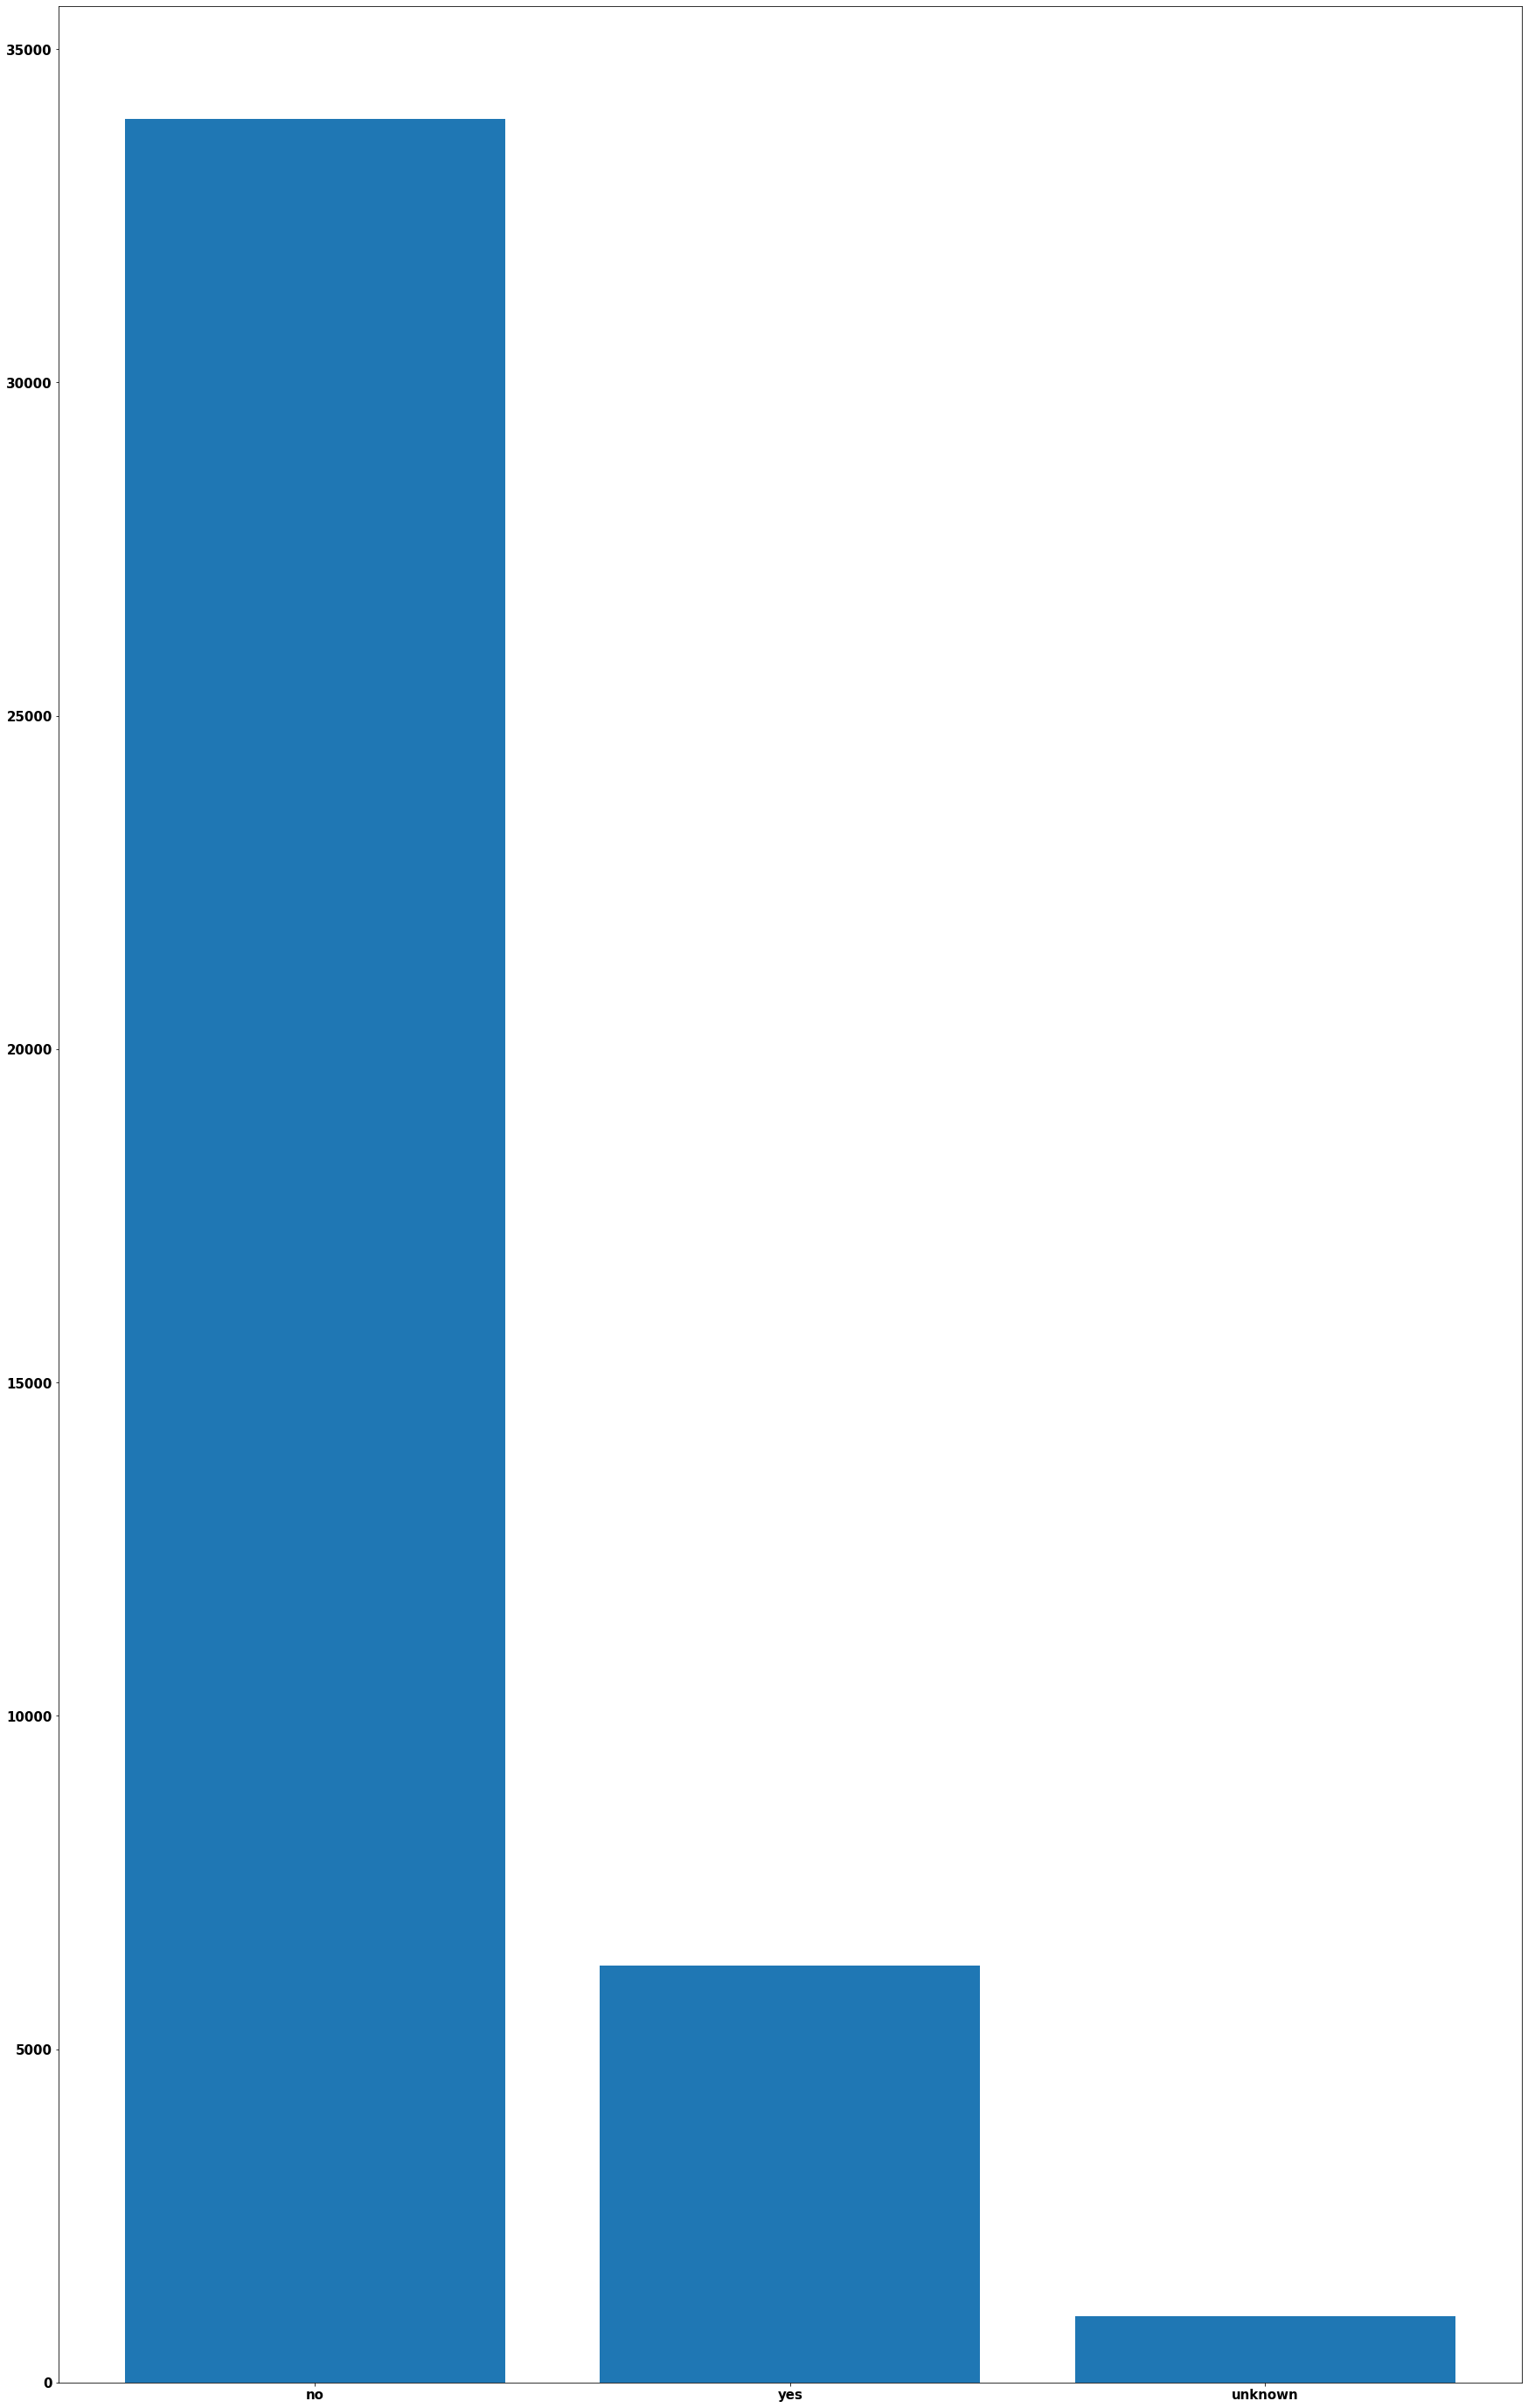

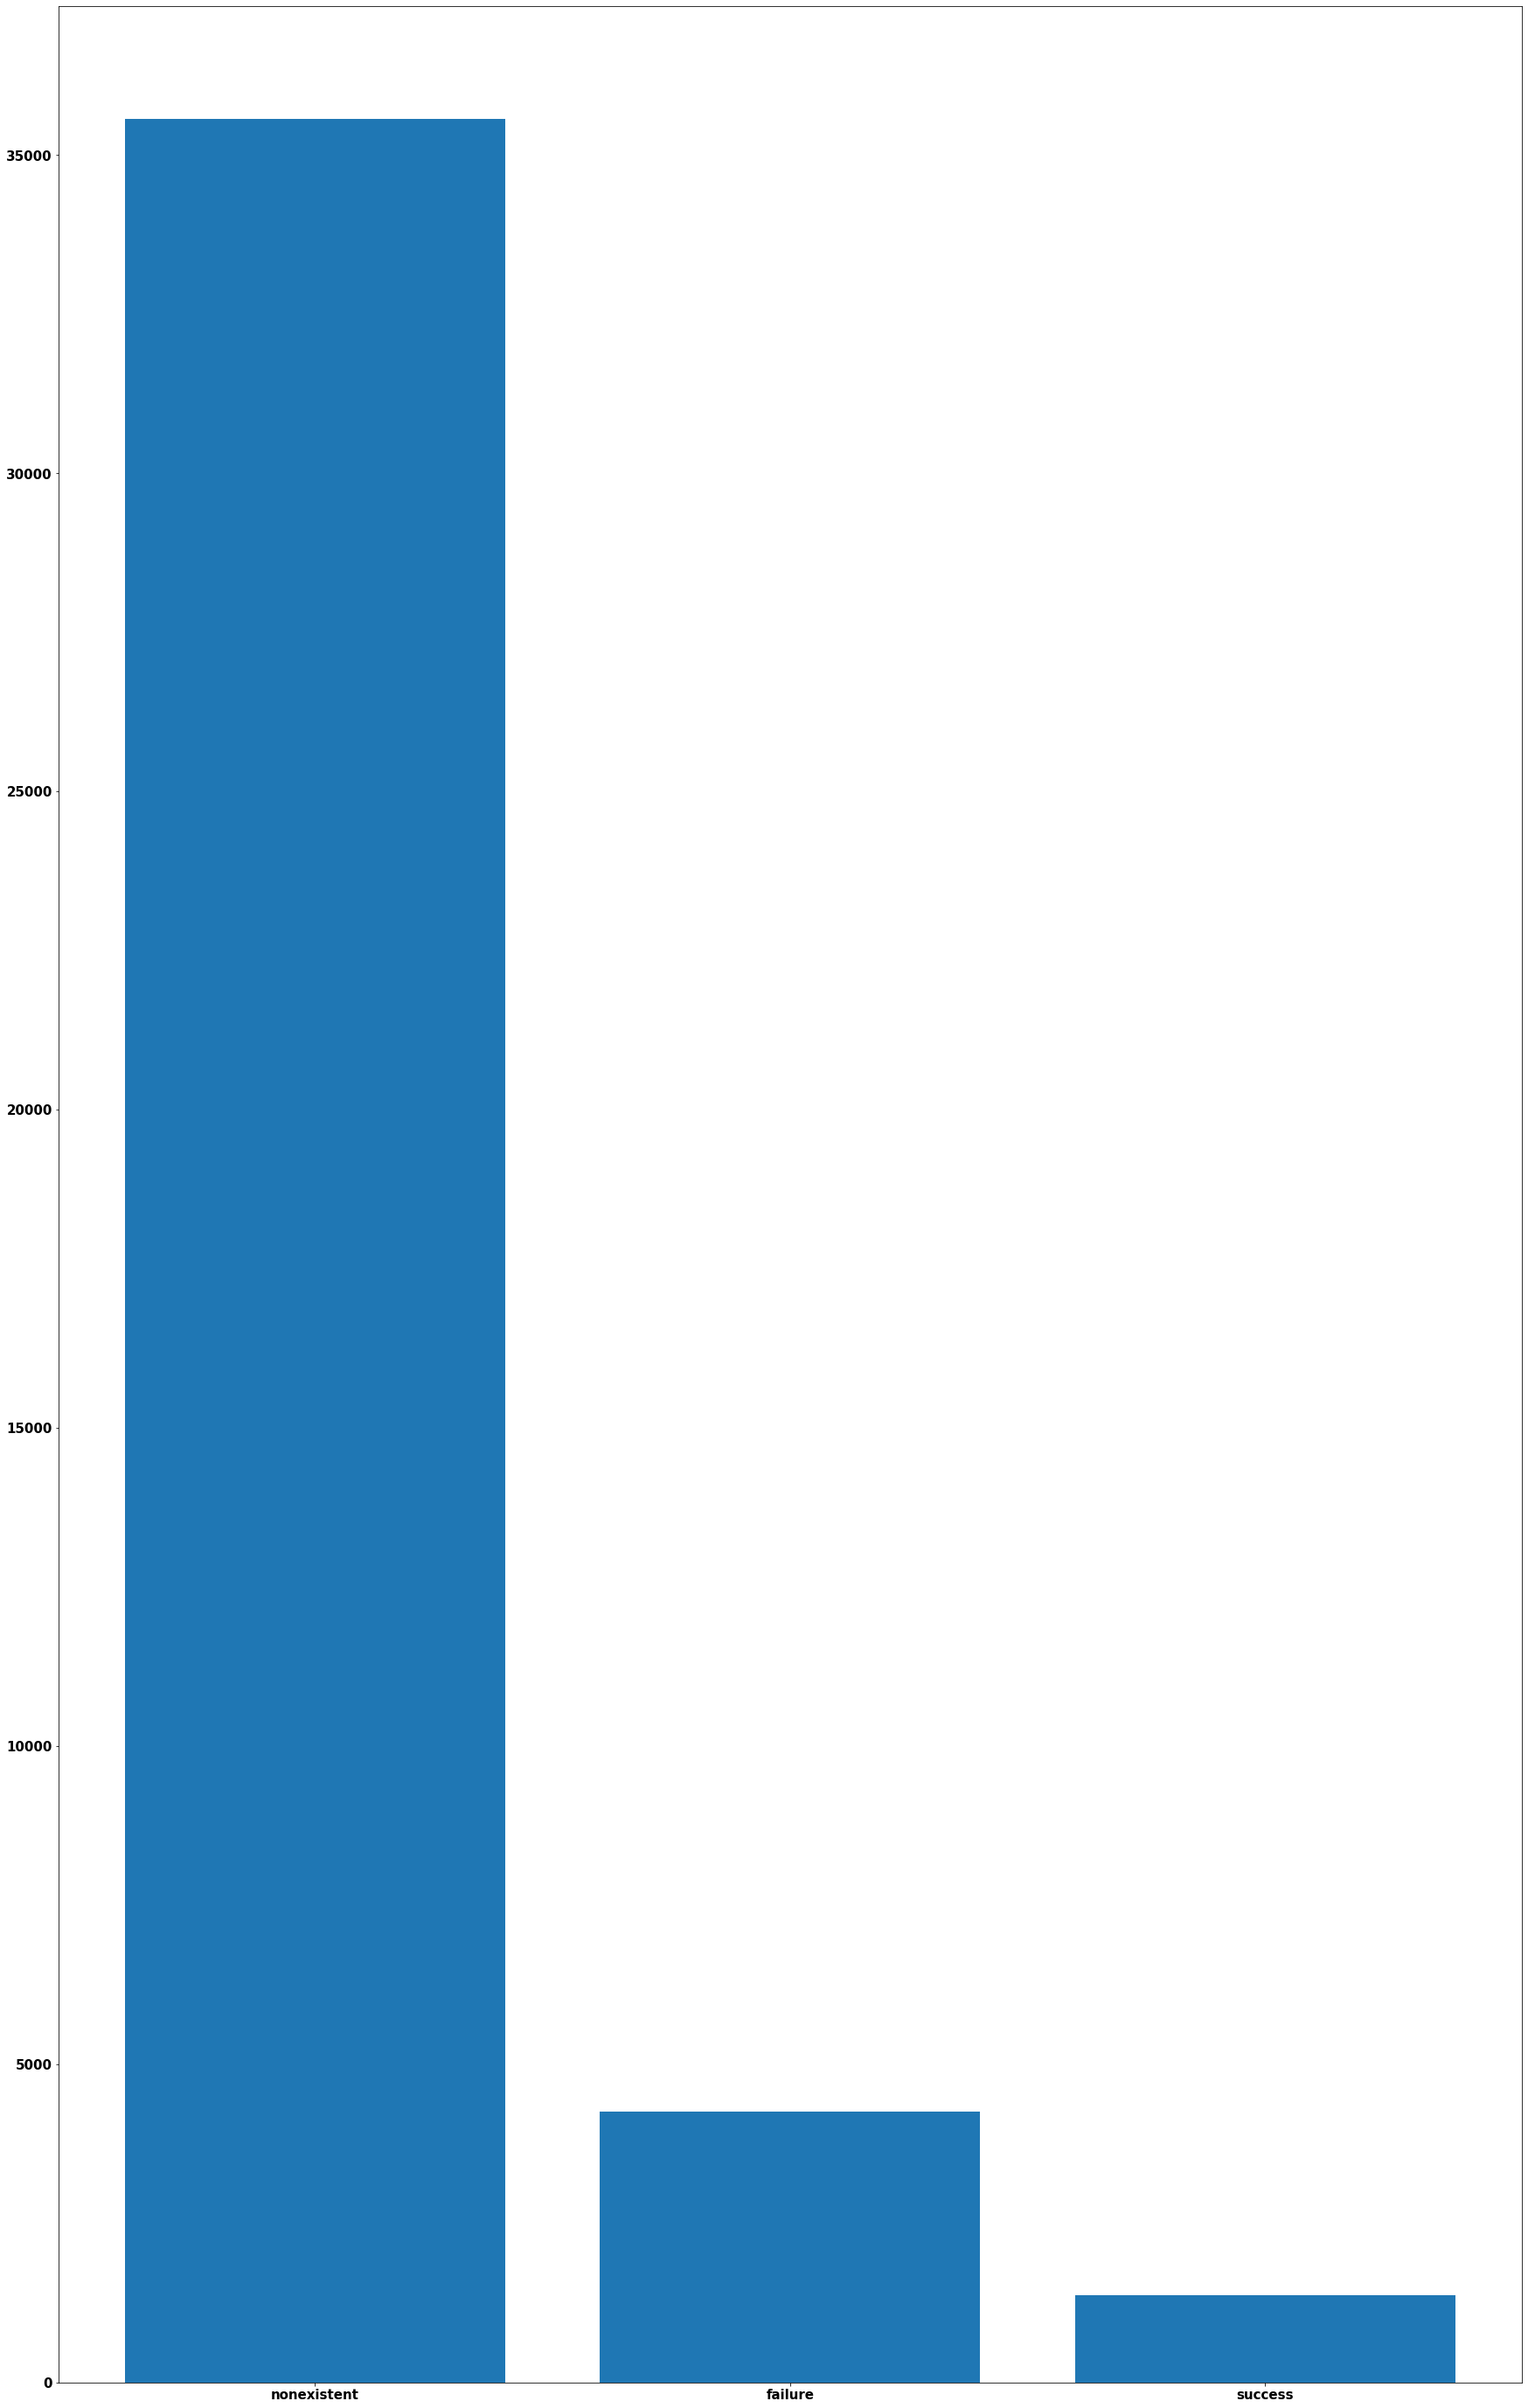

In [8]:
# fig, axs = plt.subplots(4, 2, figsize=(50, 40))
# fig.tight_layout()
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)
i = 0
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']:
    # ax = axs[int(np.floor(i/2)), i%2]
    plt.figure(figsize=(30, 50))
    plt.bar(data.loc[:, col].value_counts().index, data.loc[:, col].value_counts().values)
    # ax.set_title(col)
    i += 1
    plt.show()
    # if i == 7:
        # plt.axis('off')

# plt.savefig('cat_var.png', dpi=600)
# plt.show()

# Data cleaning

In [9]:
from sklearn.impute import KNNImputer

## Handle NA

### Marital and job

In [10]:
c_data = data.copy()
c_data.loc[:,'job'].loc[c_data.loc[:,'job']=='unknown'] = c_data.loc[:, 'job'].mode()
c_data.loc[:,'marital'].loc[c_data.loc[:,'marital']=='unknown'] = c_data.loc[:, 'marital'].mode()

c:\users\almudena\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Default, housing, loan and poutcome

In [11]:
print(c_data.loc[:,'default'].loc[c_data.loc[:,'y']=='yes'].value_counts())
c_data.loc[:,'default'].loc[c_data.loc[:,'y']=='no'].value_counts()

no         4197
unknown     443
Name: default, dtype: int64


no         28391
unknown     8154
yes            3
Name: default, dtype: int64

default is going to be ignored taking into account the distribution of the variables

In [12]:
print(c_data.loc[:,'housing'].loc[c_data.loc[:,'y']=='yes'].value_counts()/np.sum(c_data.loc[:,'housing'].loc[c_data.loc[:,'y']=='yes'].value_counts()))
c_data.loc[:,'housing'].loc[c_data.loc[:,'y']=='no'].value_counts()/np.sum(c_data.loc[:,'housing'].loc[c_data.loc[:,'y']=='no'].value_counts())

yes        0.540302
no         0.436638
unknown    0.023060
Name: housing, dtype: float64


yes        0.521752
no         0.454088
unknown    0.024160
Name: housing, dtype: float64

In [13]:
print(c_data.loc[:,'loan'].loc[c_data.loc[:,'y']=='yes'].value_counts()/np.sum(c_data.loc[:,'loan'].loc[c_data.loc[:,'y']=='yes'].value_counts()))
c_data.loc[:,'loan'].loc[c_data.loc[:,'y']=='no'].value_counts()/np.sum(c_data.loc[:,'loan'].loc[c_data.loc[:,'y']=='no'].value_counts())

no         0.829741
yes        0.147198
unknown    0.023060
Name: loan, dtype: float64


no         0.823574
yes        0.152266
unknown    0.024160
Name: loan, dtype: float64

housing and loan will be discarded due to the lack of variability between y classes.

In [14]:
print(c_data.loc[:,'poutcome'].loc[c_data.loc[:,'y']=='yes'].value_counts()/np.sum(c_data.loc[:,'poutcome'].loc[c_data.loc[:,'y']=='yes'].value_counts()))
c_data.loc[:,'poutcome'].loc[c_data.loc[:,'y']=='no'].value_counts()/np.sum(c_data.loc[:,'poutcome'].loc[c_data.loc[:,'y']=='no'].value_counts())

nonexistent    0.676940
success        0.192672
failure        0.130388
Name: poutcome, dtype: float64


nonexistent    0.887107
failure        0.099787
success        0.013106
Name: poutcome, dtype: float64

The meaning of the variable nonexistent can be considered by itself as no NA. Moreover, the percentage of nonexitent is considerably larger than the rest but considering the change between values, I will try to consider it like another value and see the impact of the model before deciding to delete the variable.

In [15]:
c_data.drop(['default', 'housing', 'loan'], axis=1, inplace=True)

### pdays

In [16]:
c_data.pdays.value_counts().sort_index()

0         15
1         26
2         61
3        439
4        118
5         46
6        412
7         60
8         18
9         64
10        52
11        28
12        58
13        36
14        20
15        24
16        11
17         8
18         7
19         3
20         1
21         2
22         3
25         1
26         1
27         1
999    39673
Name: pdays, dtype: int64

Considering the values and the frequency, I will change this column to if the client has been contacted or not.

In [17]:
c_data.loc[c_data.loc[:, 'pdays']!=999, 'pdays'] = 1
c_data.loc[c_data.loc[:, 'pdays']==999, 'pdays'] = 0

### education

In [18]:
print(c_data.loc[:,'education'].loc[c_data.loc[:,'y']=='yes'].value_counts()/np.sum(c_data.loc[:,'education'].loc[c_data.loc[:,'y']=='yes'].value_counts()))
c_data.loc[:,'education'].loc[c_data.loc[:,'y']=='no'].value_counts()/np.sum(c_data.loc[:,'education'].loc[c_data.loc[:,'y']=='no'].value_counts())

university.degree      0.359914
high.school            0.222198
professional.course    0.128233
basic.9y               0.101940
basic.4y               0.092241
unknown                0.054095
basic.6y               0.040517
illiterate             0.000862
Name: education, dtype: float64


university.degree      0.287239
high.school            0.232133
basic.9y               0.152457
professional.course    0.127175
basic.4y               0.102550
basic.6y               0.057568
unknown                0.040495
illiterate             0.000383
Name: education, dtype: float64

Categorical variables: dummy variables

Numeric variables: MinMax Scaler

In [19]:
num_col = c_data.describe().columns

In [20]:
scarler_list = []
for col in num_col:
    scaler = MinMaxScaler()
    supp_data = scaler.fit_transform(c_data[[col]])
    scarler_list.append(scaler)
    supp_data = pd.DataFrame(supp_data, columns=[col])
    c_data.drop([col], axis=1, inplace=True)
    c_data = pd.concat([c_data, supp_data], axis=1)

In [21]:
c_data.education.value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [22]:
supp_educ = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
             'university.degree', 'professional.course', 'unknown']
educ_dict = {supp_educ[i]:i for i in range(len(supp_educ))}

In [23]:
c_data.replace({'education':educ_dict}, inplace=True)

In [24]:
for col in c_data.describe(include='object').columns:
    supp_data = pd.get_dummies(c_data.loc[:,col], prefix=col, drop_first=True)
    c_data = pd.concat([c_data, supp_data], axis=1)
    c_data.drop([col],axis=1, inplace=True)

In [25]:
c_data.loc[:, 'education'].replace(7, np.nan, inplace=True)

In [42]:
imputer = KNNImputer(n_neighbors=10)
c_data_array = imputer.fit_transform(c_data)
c_data2 = pd.DataFrame(c_data_array, columns=c_data.columns)
c_data2.education = np.around(c_data2.education)

In [43]:
# We don't want any value less than 0 or greater than 6
print((c_data2.loc[c_data2.loc[:, 'education'].isnull(), 'education'] < 0).sum())
(c_data2.loc[c_data2.loc[:, 'education'].isnull(), 'education'] > 6).sum()

0


0

In [44]:
c_data2.loc[:, 'education']

0        1.0
1        4.0
2        4.0
3        2.0
4        4.0
        ... 
41183    6.0
41184    6.0
41185    5.0
41186    6.0
41187    6.0
Name: education, Length: 41188, dtype: float64

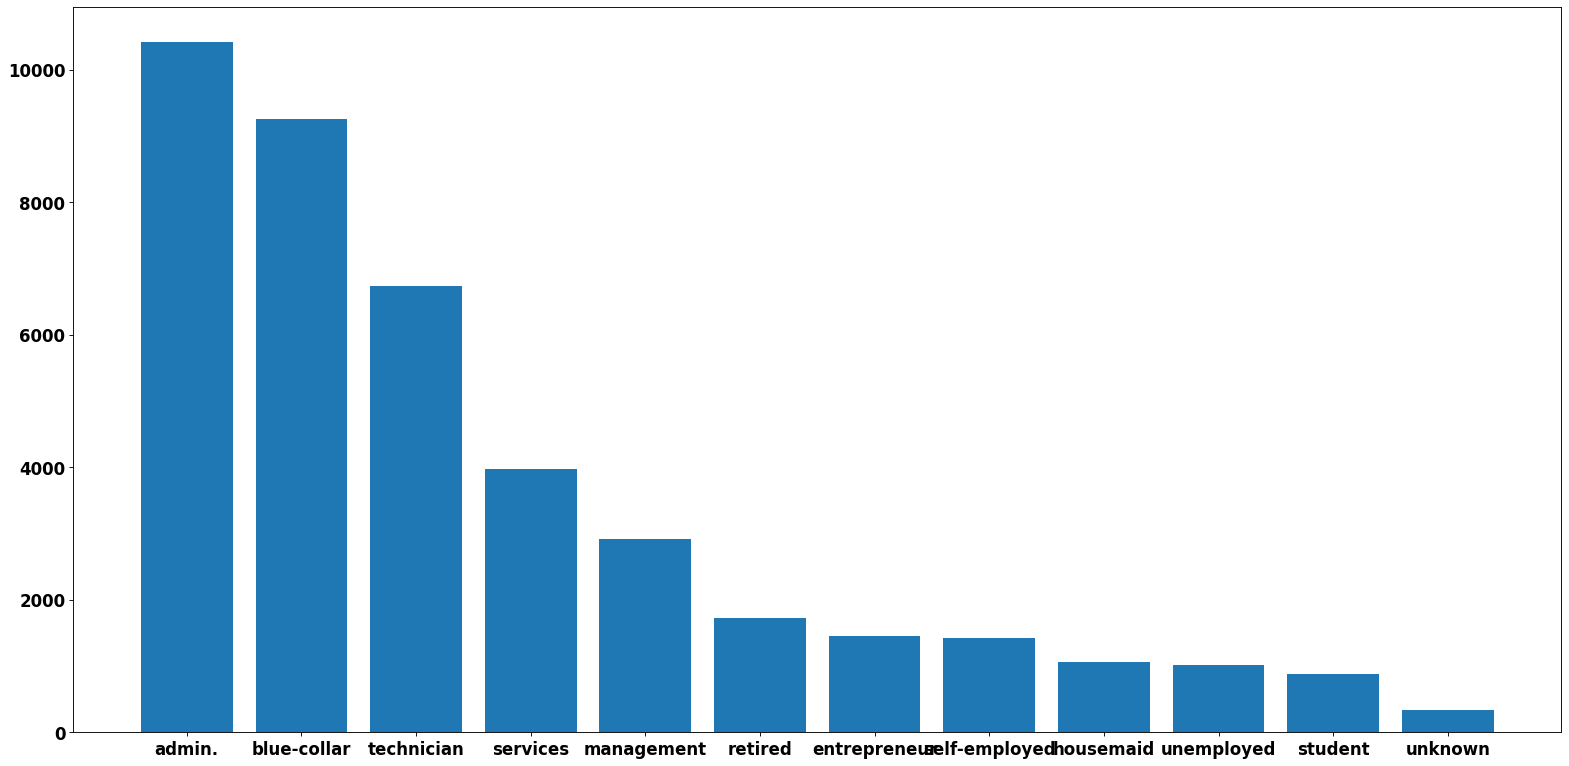

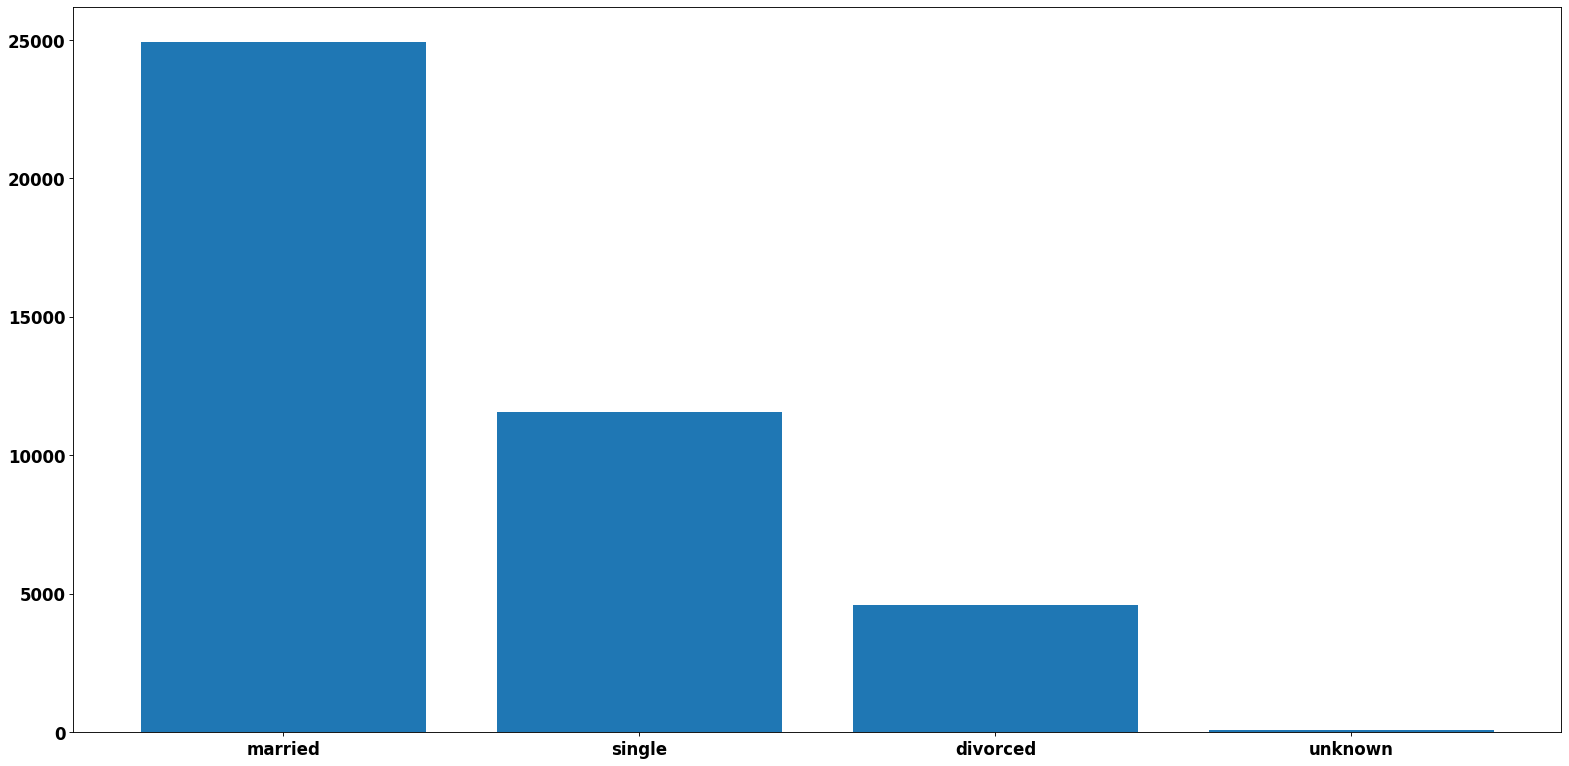

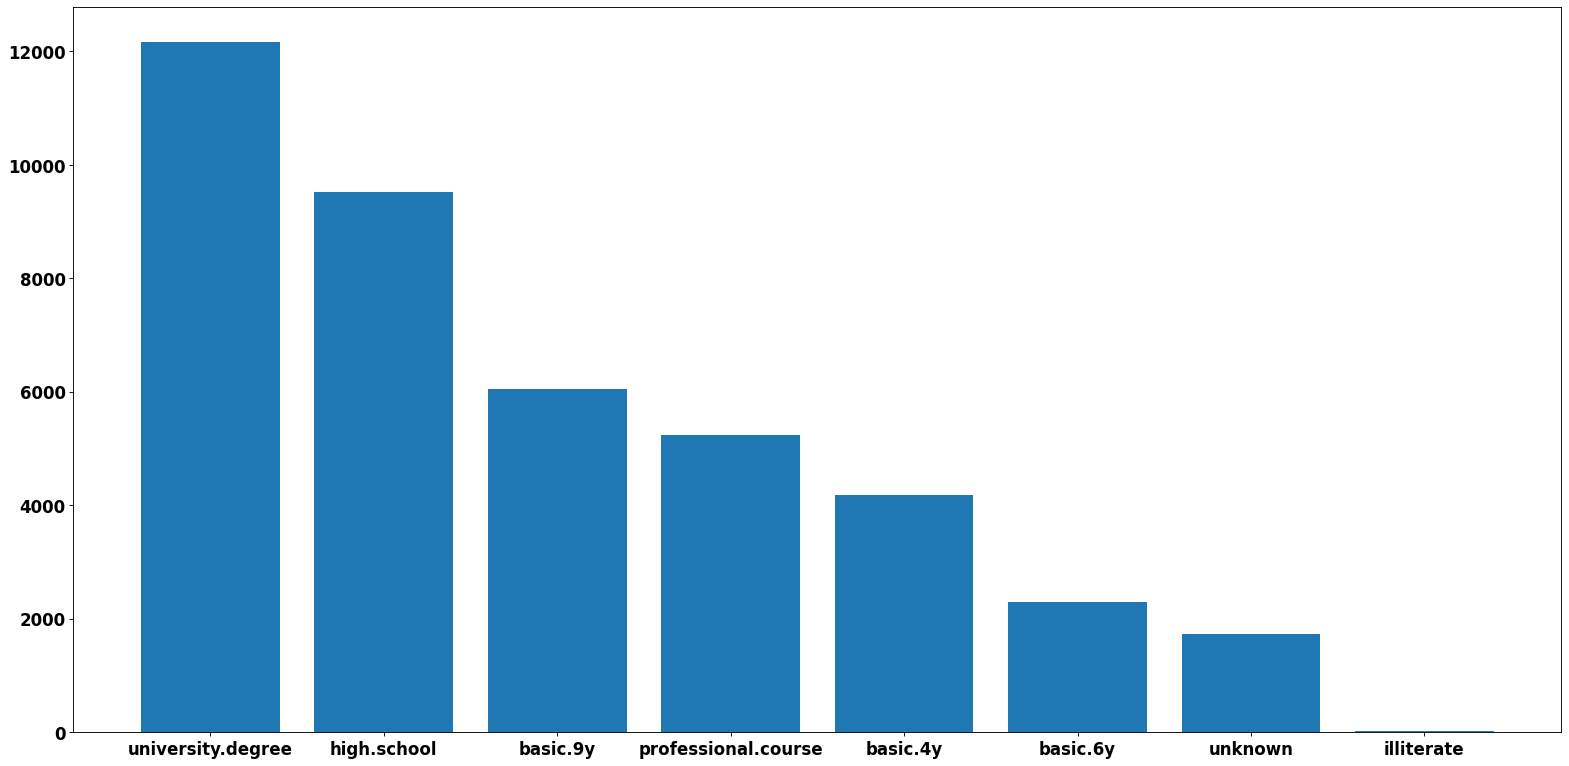

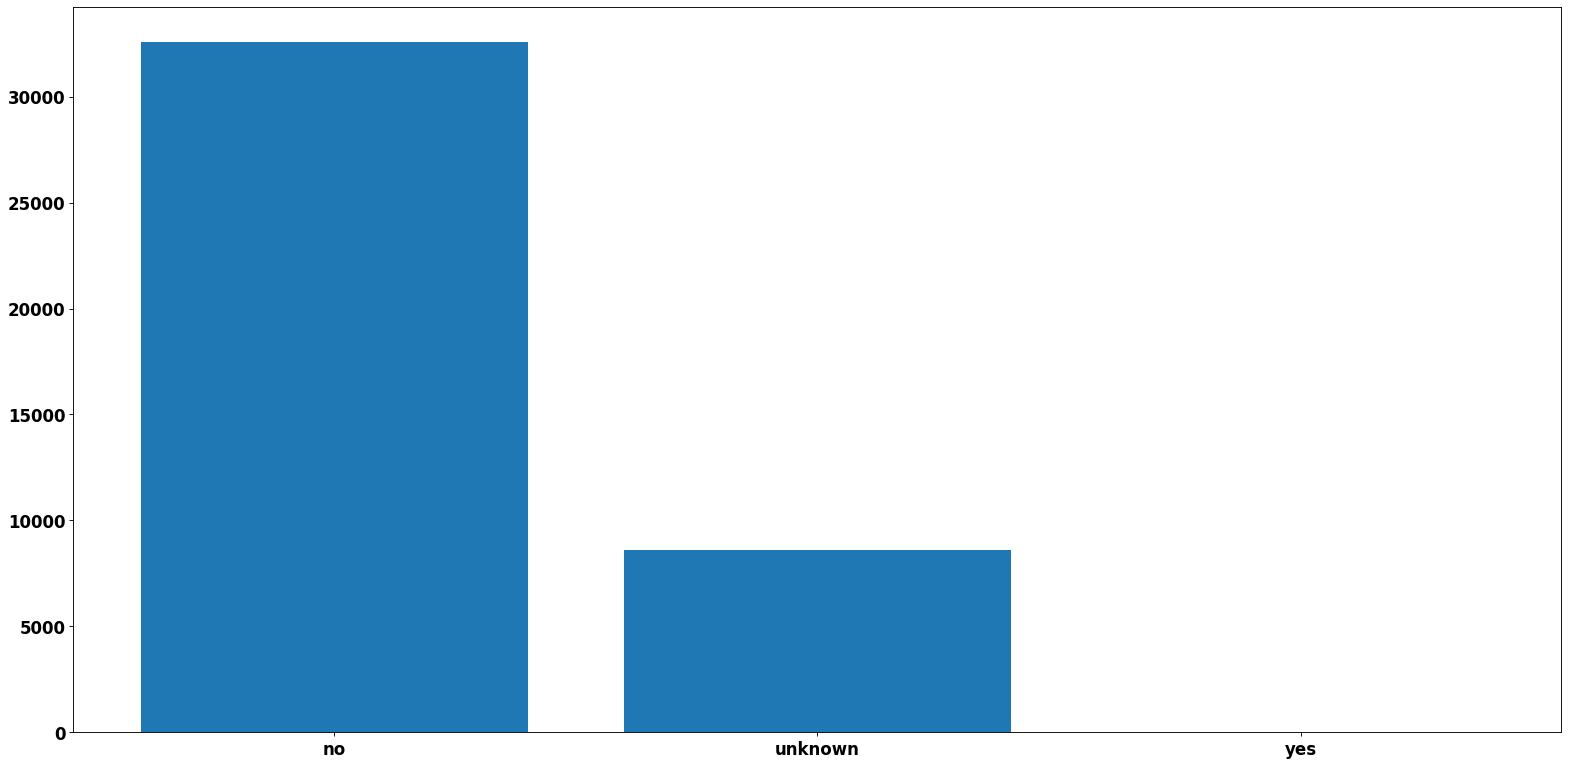

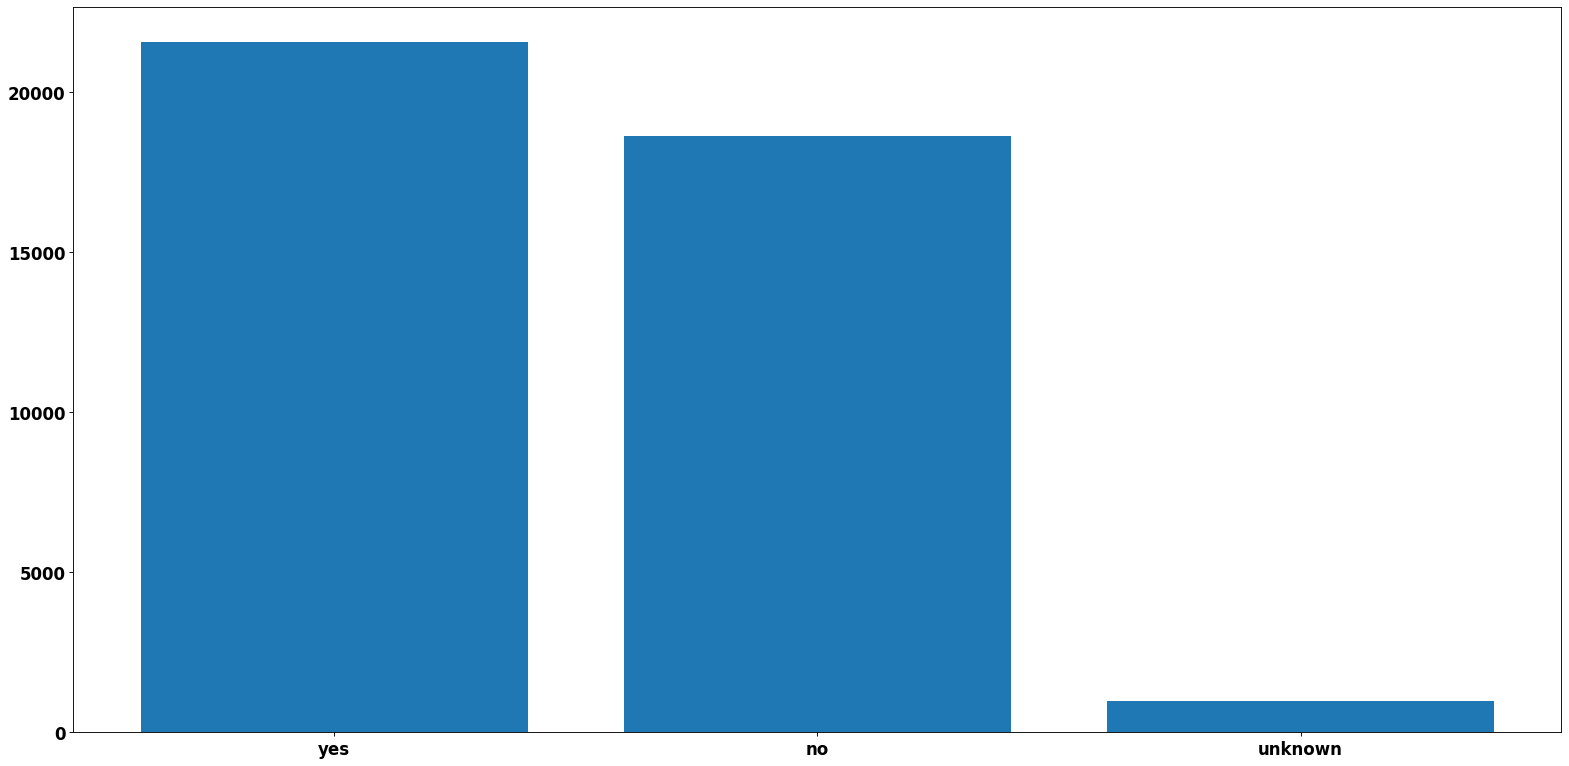

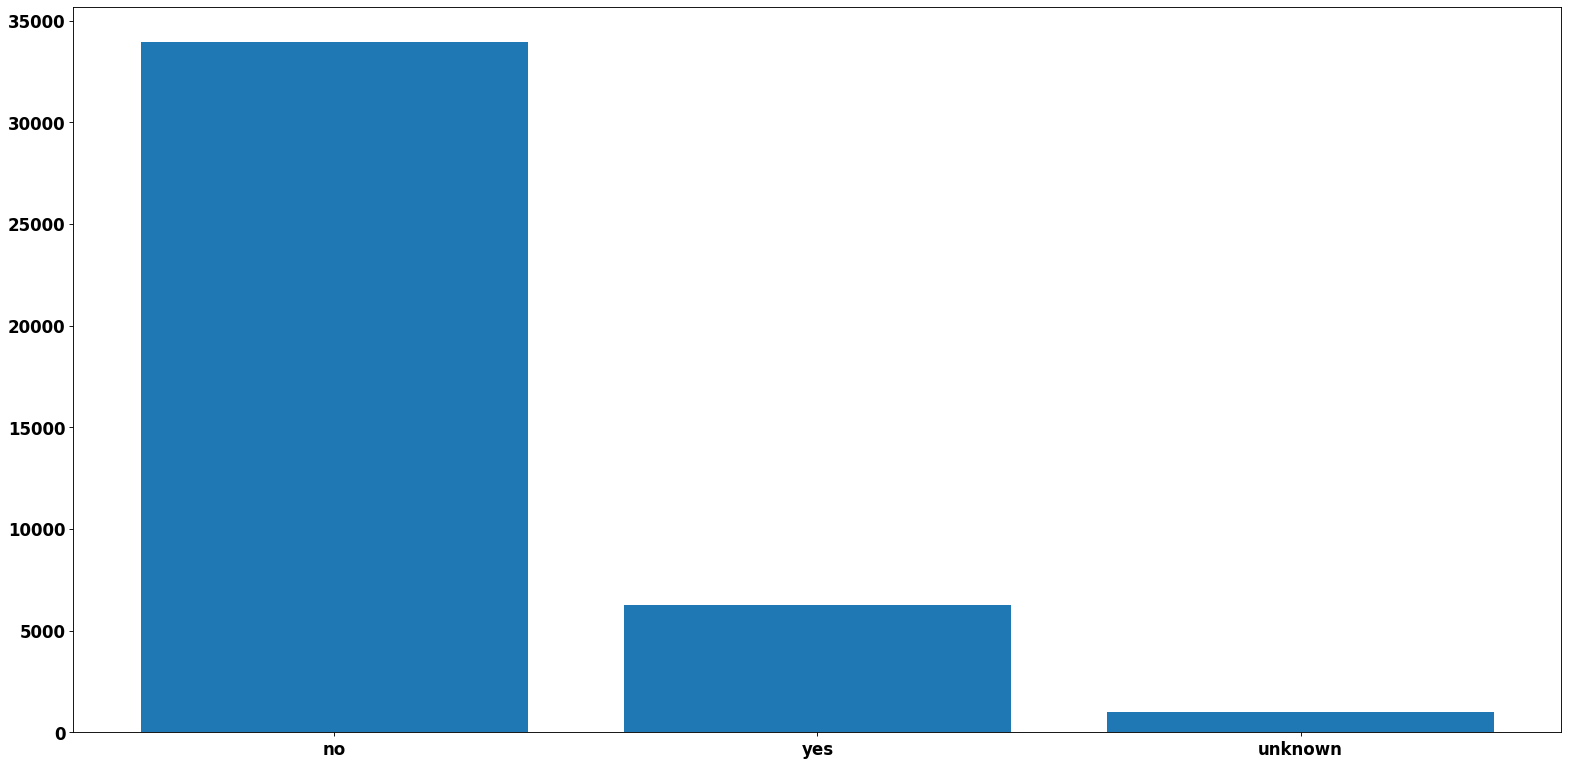

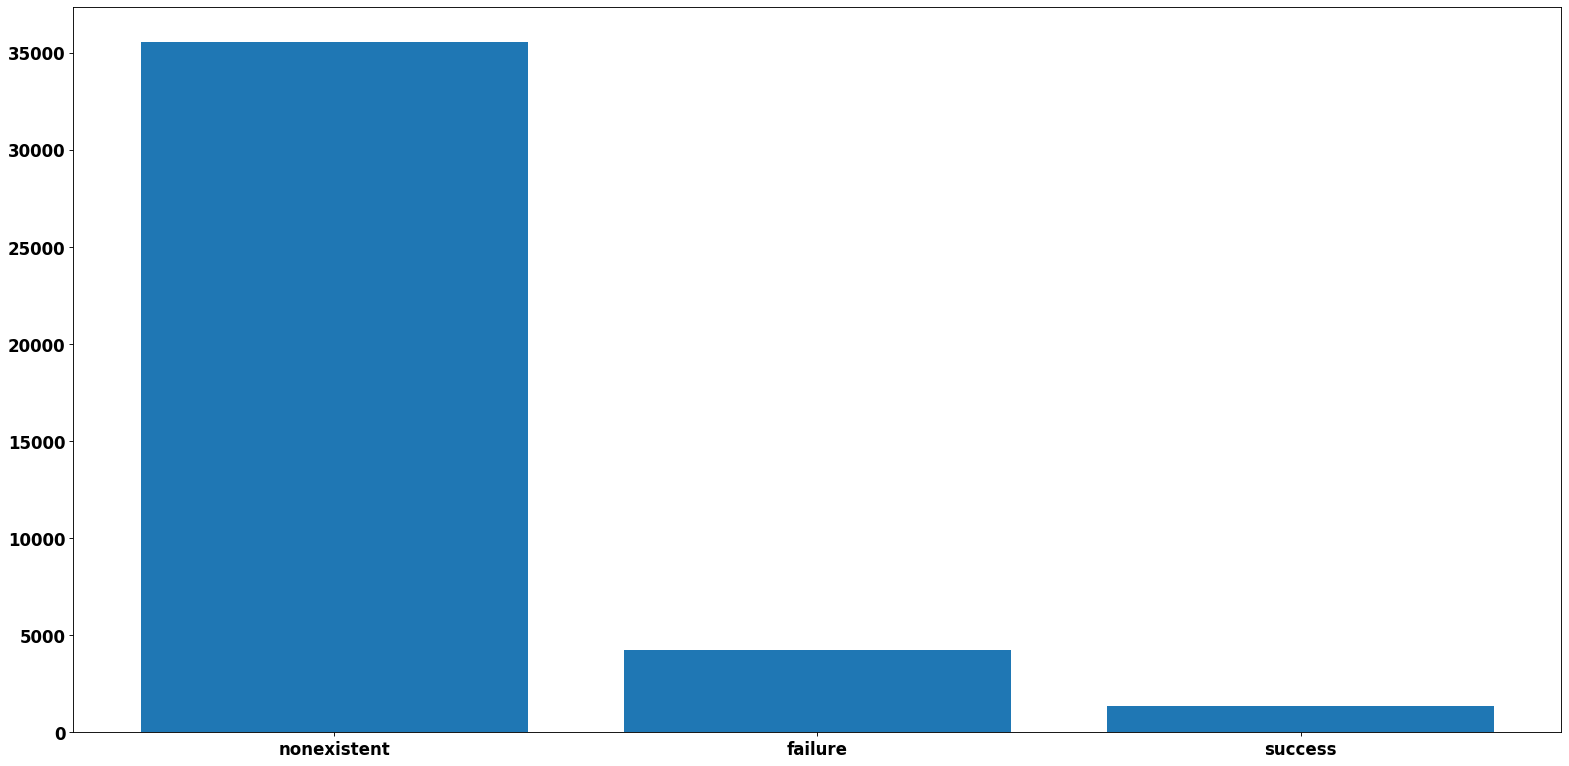

In [29]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)
i = 0
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']:
    plt.figure(figsize=(24, 12), dpi=80)
    plt.bar(data.loc[:, col].value_counts().index, data.loc[:, col].value_counts().values)
    # plt.set_title(col)
    i += 1

In [45]:
c_data3 = c_data2.copy()
for i in range(len(num_col)):
    col = num_col[i]
    scaler = scarler_list[i]
    supp_data = scaler.inverse_transform(c_data3[[col]])
    supp_data = pd.DataFrame(supp_data, columns=[col])
    c_data3.drop([col], axis=1, inplace=True)
    c_data3 = pd.concat([c_data3, supp_data], axis=1)

In [48]:
scaler = MinMaxScaler()
c_data2.education = scaler.fit_transform(c_data2.education.values.reshape(-1, 1))

In [51]:
c_data3.to_csv(f"{os.path.dirname(os.path.abspath(''))}/bank-additional/cleaned_data.csv", index=False)
c_data2.to_csv(f"{os.path.dirname(os.path.abspath(''))}/bank-additional/cleaned_data_scaled.csv", index=False)